#### Model taken from:
- Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- Modelling and Control of Offshore Marine Pipeline during Pipelay. Gullik A. Jensen et al

M(q)q ̈ + C(q,q ̇)q ̇ + H(q,q ̇)q ̇ + f(q) + g(q) = τ

In [1]:
# DONE - make sure all parameters (vessel and pipe) are in the same reference frame, e.g p.78, p.142
# DONE - do I have seabed interaction force in the model?
# DONE - applied top tension in dynamic case might have been time varying, Jensen thesis p.76-77
# DONE - do I have stinger accounted in the model? do I need stinger in the model?, see 3338.pdf
# DONE - degree - radians
# DONE - verify results against the catenary
# DONE - add more nodes

# TODO - roller reaction (force) should be proportional to pipe vertical displacement at rollers?

# TAKEAWAY - use catenary for initial input

In [2]:
import numpy as np
import math
from scipy.integrate import odeint, ode, solve_ivp
from scipy.integrate import ode
from scipy.misc import derivative
from numpy.linalg import inv, pinv
import numdifftools as nd
import tqdm
import functools
from datetime import datetime
from scipy.optimize import fsolve

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

### Inputs

In [5]:
pipe_joint_length = 2763 #250 #600 #100 # [m]
pipe_weight_per_unit_length = 96 #  (submerged) [kg/m]  # 113.07 - not submerged

q = [0.9939840275055615, 1.986772044151028, 1.9831911966919273, 1.9772469629333669] # used for initial checks only but not in final solution 
l = [pipe_joint_length for i in range(len(q))]

# mn = 5.08976 * 10e7 # mass of the vessel, [kg]
# In = 5.041*10e7 # moment of inertia of the vessel, [kg*𝑚2]
# mn = 80048 # mass of the vessel, [kg]
# In = 50410 # moment of inertia of the vessel, [kg*𝑚2]

mn = 32219000 # mass of the vessel, [kg]
# mn = 5.08976 *1e7 # mass of the vessel, [kg]

In [146]:
mn

32219000

In [6]:
# L - the hull length
# Xg - x-center of gravity

L = 169 # [m]
Xg = 78 # [m]
# L = 240 # [m]
# Xg = 120 # [m]

In [7]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [8]:
In = vessel_inertia_moment(mn,Xg,L)

In [9]:
In

253533324687.5

In [10]:
mi = [x*pipe_weight_per_unit_length for x in l] # mass of pipe element (submerged), [kg]

In [11]:
# for hydrodynamic damping matrix
Cd=[0.87, 0.87, 0.87, 1.6] # Drag coefficient
# Cd=0.82 # Drag coefficient

qw = 1025 # Water density [kg/m3]
d0 = 0.7610 # Outer diameter of pipe, [m]
dI= 0.69# Inner diameter of pipe, [m]

In [12]:
# for vector of spring forces in the pipe joints
# K = 1.4*10e11
E = 210e9 # modulus of elasticity of steel, [N/m^2]
EI = E*3.14/64*(d0**4-dI**4) # Bending stiffness [N*m^2]

K = EI#10e7 # depends on the unit bending stiffness of the pipe (EI), 
       # and the length li, of the link; from the Jensen thesis [N/m]

In [13]:
K/1e9

1.1200519217105538

In [14]:
# for vector of control inputs
tau_qn = 250576 # tension in pipe at water level, [N] (check Jee sheets)
Fx_ = 1.4e+08 #7.5e7 # 5e7 # [N], from the Jensen thesis
# Fy=-100*1000 # [N],

In [15]:
# for solution
max_t = 600  
dt = 0.5
t=np.arange(0,max_t,dt)
# q0=[45, 0, 20, 0, 15, 0, 5, 0]

In [16]:
Awp = 1000 # the waterplane area of the vessel, [m^2]
# h=26.3 # water depth, [m]
h=700

# fip=1e10
fip=1e12

In [17]:
kp=1.95e4
# T = 200 # Measure the period of oscillation, from experiments
# kd=0.075*kp*T 
kd=1.5e4
# kd=0.5e8 # change 

### System inertia matrix 

In [18]:
def alpha(q):
    sum_=0
    ans=[]
    for i in range(len(q)):
        sum_+=q[i]
        ans.append(sum_)
    return np.array(ans)

In [19]:
def Jv(q, i, l):
    alp=alpha(q)
    def Jv0(i, k, alp, l):
        
        if k<i:
            tmp1=np.dot(np.array(l[k:i]),np.sin(np.radians(alp[k:i])))
            tmp1=-tmp1-0.5*l[i]*np.sin(np.radians(alp[i]))
            
            tmp2 =np.dot(np.array(l[k:i]),np.cos(np.radians(alp[k:i])))
            tmp2=tmp2+0.5*l[i]*np.cos(np.radians(alp[i]))
                        
            return np.array([tmp1, tmp2]).T
        elif k==i:
            return np.array([-0.5*l[i]*np.sin(np.radians(alp[i])),
                    0.5*l[i]*np.cos(np.radians(alp[i]))]).T
        else:
            return np.array([0, 0]).T                 
    
    ans=np.array([Jv0(i, k, alp, l) for k in range(len(q))])
    
    return ans.T

In [20]:
Jv(q, 2, l)

array([[-311.14808342, -263.21715145, -119.53964925,    0.        ],
       [6898.16451361, 4135.58028398, 1376.31846687,    0.        ]])

In [21]:
def Jomega(i,q):

    def Jomega0(i,k):
        if k<=i:
            return 1
        return 0
    ans=np.array([Jomega0(i, k) for k in range(len(q))])
   
    return ans.reshape(len(q),1).T

In [22]:
def M(q, l, mn, In, mi):
  
    
    sum1 = mn * np.dot(Jv( q, len(q)-1, l).T, Jv(q, len(q)-1, l))
    
 
    sum2 = In * np.dot(Jomega(len(q)-1,q).T, Jomega(len(q)-1,q))
    
    sum3=0
    
    for i in range(len(q)-1):
        J_v = Jv(q, i, l)
        sum3+=mi[i]*np.dot(J_v.T, J_v)
      
    return sum1 + sum2 + sum3   

In [23]:
M(q, l, mn, In, mi)

array([[3.02720849e+15, 2.15912818e+15, 1.29225988e+15, 4.29663965e+14],
       [2.15912818e+15, 1.54156929e+15, 9.23554020e+14, 3.07343239e+14],
       [1.29225988e+15, 9.23554020e+14, 5.54035229e+14, 1.84654279e+14],
       [4.29663965e+14, 3.07343239e+14, 1.84654279e+14, 6.17448561e+13]])

### Coriolis-centripetal matrix

In [24]:
# TODO - not sure about this formula 
def C(q, dq, l, mn, In, mi): #here
    ans = np.zeros((len(q),len(q)))              
    fun = lambda q: M(q, l, mn, In, mi)
    Dfun = nd.Gradient(fun) 
    
    dq1_, dq2_, dq3_, dq4_ = Dfun(q)
    diff = np.array([dq1_, dq2_, dq3_, dq4_])
    
    def c(i,j,k):
        return 0.5 *(diff[k].item((i,j))+
                     diff[j].item((i,k))-
                     diff[i].item((j,k)))
    
    for i in range(len(q)):
        for j in range(len(q)):
            for k in range(len(q)):
                ans[i][j]+=c(i,j,k)*np.radians(dq[k])
    return ans                  

In [25]:
dq=[1,1,0.5,1]

In [26]:
C(q, dq, l, mn, In, mi)

array([[ 5.35255986e-03,  2.17932494e+10,  3.08223034e+10,
         1.97267543e+10],
       [-4.35864987e+10, -5.85996236e+09,  8.42838240e+09,
         9.05239594e+09],
       [-6.16446067e+10, -3.04921838e+10, -9.73615886e+09,
        -6.50570818e+08],
       [-3.94535087e+10, -2.39271692e+10, -1.22836091e+10,
        -6.14395000e+09]])

### Hydrodynamic damping matrix

In [27]:
def R_I_Bi(i, alp):
    return np.array([[np.cos(np.radians(alp[i])), -np.sin(np.radians(alp[i]))],
                    [np.sin(np.radians(alp[i])), np.cos(np.radians(alp[i]))]])

In [28]:
alp=alpha(q)

In [29]:
R_I_Bi(2, alp)

array([[ 0.99624934, -0.08652888],
       [ 0.08652888,  0.99624934]])

In [30]:
I_=np.array([[0,0],
             [0,1]])

In [31]:
def Pi(i,alp):
    return np.dot(np.dot(R_I_Bi(i, alp),I_),R_I_Bi(i, alp).T)

In [32]:
# TODO - not sure about this formula 
def mod_Vn(q, alp, dq):
    ans=[]
    for j in range(len(q)):
        ans.append(np.dot(np.dot(Pi(j,alp),Jv( q,j, l)), np.radians(dq)))
    return np.linalg.norm(np.array(ans))

In [33]:
mod_Vn(q,alp,dq)

416.7166853577408

In [34]:
# TODO - not sure about this formula 
def mod_Vni(i,q,alp,dq):
    return np.linalg.norm(np.dot(np.dot(Pi(i,alp),Jv( q,i, l)), np.radians(dq)))

In [35]:
mod_Vni(len(q)-1,q,alp,dq)

349.0583462872576

In [36]:
def gamma(i):
    return 0.5*Cd[i]*qw*d0*l[i]

In [37]:
def H(alp,q,dq,l):
    ans=np.zeros((len(q), len(q)))
    alp=alpha(q)
    for j in range(len(q)):
        ans+=gamma(j)*mod_Vni(j,q,alp,dq)*np.dot(np.dot(Jv(q,j,l).T,Pi(j,alp)),Jv( q,j, l))
    return ans    

In [38]:
print(alp)
print(q)

[0.99398403 2.98075607 4.96394727 6.94119423]
[0.9939840275055615, 1.986772044151028, 1.9831911966919273, 1.9772469629333669]


In [39]:
H(alp,q,[0,0,0,0.1],l)

array([[3.86925132e+14, 2.76706657e+14, 1.66156380e+14, 5.54074527e+13],
       [2.76706657e+14, 1.97884726e+14, 1.18825510e+14, 3.96242315e+13],
       [1.66156380e+14, 1.18825510e+14, 7.13521564e+13, 2.37934964e+13],
       [5.54074527e+13, 3.96242315e+13, 2.37934964e+13, 7.93431484e+12]])

### Vector of spring forces in the pipe joints

In [40]:
def f(q,k):
    ans=np.array([k*q[i] for i in range(len(q))])
    return ans.reshape(len(q),1)

### Vector of gravitational/buoyancy forces

In [41]:
q

[0.9939840275055615, 1.986772044151028, 1.9831911966919273, 1.9772469629333669]

In [42]:
def x(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.cos(np.radians(alp[:i])))

    tmp1+=0.5*l[i]*np.cos(np.radians(alp[i]))
    return tmp1

In [43]:
x(alp,2,l)

6898.164513606359

In [44]:
def y(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.sin(np.radians(alp[:i])))
#     print(l,alp[i],alp)
#     print(math.sin(math.radians(alp[i])))
    tmp1+=0.5*l[i]*np.sin(np.radians(alp[i]))
    return tmp1

In [45]:
y(alp,2,l)

311.1480834242025

In [46]:
G=np.array([0,-9.81]).T

def ggi(i,G):
    return mi[i]*G
   
    
def gbi(G,l,i):
    return -3.14*l[i]*(d0**2/4)*qw*G 

# not complete formula
def gt(alp,fip, i): 
    return -fip*np.radians(alp[i])


In [47]:
# TODO understand the commeted part and incorporate it in model 
def g(q,alp):
    sum_=0
    for i in range(len(q)-1):
        sum_+=np.dot(Jv( q,i, l).T,ggi(i,G)+gbi(G,l,i))
#     print(-qw)   
#     print(Awp)
#     print(y(alp,len(alp)-1,l))
#     print(h)
#     print(-qw,Awp,y(alp,len(q)-1,l),h)
    tmp = -qw*Awp*(y(alp,len(alp)-1,l)-h)*G 
    sum_ += np.dot(Jv(q,len(q)-1, l).T, tmp)  #- \
#         np.dot(Jomega(len(q)-1).T, gt(q, fip, len(q)-1)).reshape(len(q),) 
    return sum_.reshape(len(q),1)   

In [48]:
g(q,alp)

array([[-9.80321218e+12],
       [-7.02914462e+12],
       [-4.23074288e+12],
       [-1.41145604e+12]])

### Vector of control inputs

In [49]:
# Assume that the stinger is shorter than the link length li for any link i
def tau_q(q,tau_qn): 
    ans= np.array([0 for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_qn
    return ans
# tau_q - control forces from the stinger 

In [50]:
def Fx(q,alp,dq,kp, kd, x_ref = 0):
#     print(-kp*(x(q,len(q)-1,l)-x_ref))
#     return -kp*(x(q,len(q)-1,l)-x_ref) - kd*np.dot(np.dot(Pi(len(q)-1,q),Jv( q, len(q)-1, l)), np.radians(dq)) 
    return -kp*(x(alp,len(q)-1,l)-x_ref) - kd*mod_Vn(q,alp,dq)

In [51]:
Fx(q,alp,dq,kp, kd, x_ref = 0)

-194344972.8231884

In [52]:
F1=np.array([Fx_,0]).reshape(2,1) # actuates the vessel in the surge direction in frame Bn
# F=np.array([0,Fy]).reshape(2,1)
def tau_t(q, F):
    tmp= np.dot(Jv(q,len(q)-1, l).T, F)
    return tmp
#     ans=np.zeros((len(q),1))
#     ans[-1][0]=tmp[-1][0]
#     return  ans # the thruster forces

In [53]:
tau_t(q, F1)

array([[-8.36699924e+10],
       [-7.69596619e+10],
       [-5.68448116e+10],
       [-2.33737098e+10]])

In [54]:
tau_q_wave=9e6 # (taken from article on forces to semi-submersible platform),[N]
# this function purly my invention
# TODO - for improvement see Jensen thesis p. 49
def tau_wave(q,alp, tau_q_wave):
    Y0=y(alp,0,l)
    C=np.exp(y(alp,len(q)-1,l))-np.exp(y(alp,0,l))
    ans=[]
    for i in range(len(q)):
        ans.append([tau_q_wave/C*(np.exp(y(alp,i,l))-np.exp(y(alp,0,l)))])   
    return np.array(ans)

In [55]:
def tau(q, alp, tau_qn, F, tau_q_wave):
#     return tau_q(q,tau_qn) + tau_t(q, F) + tau_wave(q, tau_q_wave)
#     return tau_t(q, F) + tau_wave(q, tau_q_wave)
#     return  tau_t(q, F)
    return tau_t(q, F) + tau_wave(q, alp, tau_q_wave)

In [56]:
# f1=C*eh1+b
# f2=C*eh2+b

# f1=C*(eh1-eh2)
# f2=f1/(eh1-eh2)eh2+b
# b=

In [57]:
q,alp

([0.9939840275055615,
  1.986772044151028,
  1.9831911966919273,
  1.9772469629333669],
 array([0.99398403, 2.98075607, 4.96394727, 6.94119423]))

In [58]:
tau_wave(q,alp, tau_q_wave)

array([[0.00000000e+000],
       [2.60965835e-201],
       [3.39755801e-118],
       [9.00000000e+006]])

In [59]:
tau(q, alp, tau_qn, F1, tau_q_wave)

array([[-8.36699924e+10],
       [-7.69596619e+10],
       [-5.68448116e+10],
       [-2.33647098e+10]])

### Static solution

In [60]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [61]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]

In [62]:
# lift_off_slope = 62#30.6 # from Jee catenary sheet, [deg]

In [63]:
# Fx_=250000 # [N]

In [64]:
# horizontal_length =(Fx_/Ws)*math.asinh(np.tan(np.radians(lift_off_slope)))

# below from Jensen thesis 

# Fx_=52347339
# a0=Fx_/(Ws*h)
# a1=math.sqrt(2*a0+1)/a0

# horizontal_length=h*np.log((a1+math.sqrt(a1**2+1))**a1)

In [65]:
# http://abc-moorings.weebly.com/catenary-calculator.html

In [66]:
Fx_0=82945396

In [67]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [68]:
horizontal_length

11052.68484446162

In [69]:
number_of_elements=4

In [70]:
delta_x=horizontal_length/number_of_elements

In [71]:
x0=[i*delta_x for i in range(number_of_elements+1)]
y0=[]
for i in range(len(x0)):
    y0.append(catenary(x0[i],Ws,Fx_))

In [72]:
x0

[0.0,
 2763.171211115405,
 5526.34242223081,
 8289.513633346216,
 11052.68484446162]

In [73]:
q=[]
l_=[]
deg_=[0]

for i in range(len(x0)-1):
    l_.append(np.sqrt((x0[i+1]-x0[i])**2+(y0[i+1]-y0[i])**2))
    deg =np.degrees(math.atan((y0[i+1]-y0[i])/(x0[i+1]-x0[i])))
    q.append(deg-deg_[-1]) 
    deg_.append(deg)


In [74]:
alp_=alpha(q)

In [75]:
q

[0.5324914472404209,
 1.0647989485770295,
 1.0642474284519123,
 1.0633292855171863]

In [76]:
l_

[2763.290547654398, 2764.2453018073493, 2766.1551399557356, 2769.0207218985934]

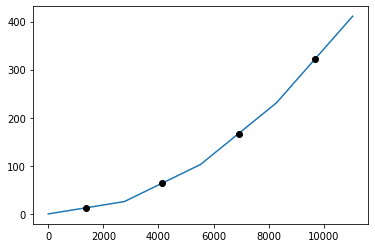

In [77]:
plt.plot(x0, y0)
plt.plot(x(alp_,0,l_),y(alp_,0,l_), 'o', color='black')
plt.plot(x(alp_,1,l_),y(alp_,1,l_), 'o', color='black')
plt.plot(x(alp_,2,l_),y(alp_,2,l_), 'o', color='black')
plt.plot(x(alp_,3,l_),y(alp_,3,l_), 'o', color='black')
plt.show()

In [78]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [79]:
q0

[0.5324914472404209,
 0,
 1.0647989485770295,
 0,
 1.0642474284519123,
 0,
 1.0633292855171863,
 0]

In [80]:
q,dq,kp

([0.5324914472404209,
  1.0647989485770295,
  1.0642474284519123,
  1.0633292855171863],
 [1, 1, 0.5, 1],
 19500.0)

In [81]:
alp_=alpha(q)

In [82]:
F_=np.array([-Fx(q,alp_,dq,kp, 0, x_ref = 0),0]).reshape(2,1)

In [83]:
F_

array([[1.88436459e+08],
       [0.00000000e+00]])

In [84]:
def static_func(q):
    alp=alpha(q)
    ans=  f(q, K) + g(q,alp) - tau(q,alp, tau_qn, F_, 0)
    return ans.reshape((len(q),))

In [85]:
root = fsolve(static_func, np.array(q))

In [86]:
root

array([0.73313185, 2.7956858 , 2.83780397, 1.35186778])

In [87]:
q=list(root)

In [88]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [89]:
alp_=alpha(root)

In [90]:
alp_

array([0.73313185, 3.52881765, 6.36662161, 7.71848939])

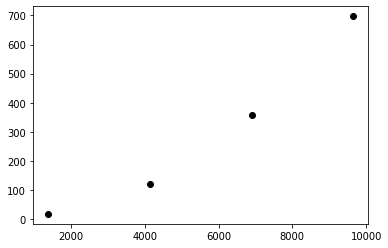

In [91]:
plt.plot(x(alp_,0,l),y(alp_,0,l), 'o', color='black')
plt.plot(x(alp_,1,l),y(alp_,1,l), 'o', color='black')
plt.plot(x(alp_,2,l),y(alp_,2,l), 'o', color='black')
plt.plot(x(alp_,3,l),y(alp_,3,l), 'o', color='black')
plt.show()

In [92]:
q

[0.7331318501868566, 2.7956857962718002, 2.837803967849071, 1.3518677796322582]

In [93]:
q0

[0.7331318501868566,
 0,
 2.7956857962718002,
 0,
 2.837803967849071,
 0,
 1.3518677796322582,
 0]

In [94]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, [q])))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, [q])))

add6=functools.partial(g,alp=alp_)
add6__g =np.array(list(map(add6, [q])))

print(datetime.now() - startTime)

0:00:00.005382


In [95]:
tmp__1=pinv(add1__Jv.transpose(0, 2, 1))
tmp__2= add5__f + add6__g

In [96]:
tmp__=np.matmul(tmp__1, tmp__2)

In [97]:
dim1=int(max_t/dt)
dim2=dim1-1

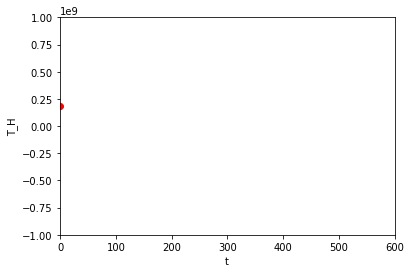

In [98]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'o', color='red')
plt.xlim([-1, dim1//2])
plt.ylim([-1000000000, 1000000000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

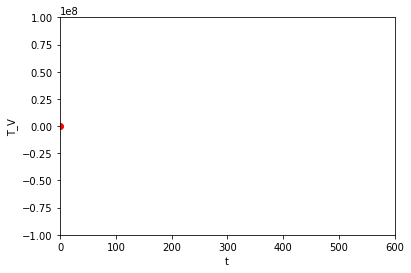

In [99]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'o', color='red')
plt.xlim([-1, dim1//2])
plt.ylim([-100000000, 100000000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [100]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([1.88436459e+08]), array([1.12522393e-05]))

### Dynamic solution 

In [101]:
from scipy.linalg import lu_factor, lu_solve

In [102]:
def manipulator(Q, t, q):
    q0,dq0,q1,dq1,q2,dq2,q3,dq3 = Q
    QI=np.array([q0,q1,q2,q3]).reshape(len(q),1)
    dQ=np.array([dq0,dq1,dq2,dq3]).reshape(len(q),1)
    
    QI= QI.flatten().tolist()
    
    alp=alpha(QI)
#     print(alp)
    
#     F0=-Fx(QI,alp,dQ, kp, kd, x_ref = 0)
    
#     if 100<t<120:
#         F=np.array([F0+1e6/120*t, 0]).reshape(2,1)
#     elif 120<t<150:
#         F=np.array([F0+1e6, 0]).reshape(2,1)
#     elif 150<t<170:
#         F=np.array([F0+1e6-1e6/170*t, 0]).reshape(2,1)
#     else:
#         F=np.array([F0, 0]).reshape(2,1)

#     if 40<t<60:
#         F=np.array([Fx_+1e6/60*t, 0]).reshape(2,1)
#     elif 60<t<80:
#         F=np.array([Fx_+1e6, 0]).reshape(2,1)
#     elif 80<t<100:
#         F=np.array([Fx_+1e6-1e6/100*t, 0]).reshape(2,1)
#     elif t>100:
#         F0=-Fx(QI,alp,dQ, kp, kd, x_ref = 0)
#         F=np.array([F0, 0]).reshape(2,1)
#     else:
#         F=np.array([Fx_, 0]).reshape(2,1)
        
        
#     if 100<t:
#         F=np.array([-Fx(QI,alp, dQ, kp, kd, x_ref = 0),0]).reshape(2,1)
#     else:
#         F=np.array([Fx_,0]).reshape(2,1) 

#     if 100<t<130:
#         F=np.array([-Fx(QI, alp, dQ, kp, 0, x_ref = 0),0]).reshape(2,1)
#     elif t>130:
#         F=np.array([-Fx(QI, alp, dQ, kp, kd, x_ref = 0),0]).reshape(2,1)
#     else:
#         F=np.array([Fx_,0]).reshape(2,1)

    if t>100:
        F=np.array([-Fx(QI, alp, dQ, kp, kd, x_ref = 0),0]).reshape(2,1)
    else:
        F=np.array([Fx_,0]).reshape(2,1)
   
    
    ddq0,ddq1,ddq2,ddq3 = np.linalg.lstsq(M(QI, l, mn, In, mi), 
                        - np.dot(H(alp,QI,dQ,l), np.radians(dQ)).reshape(len(QI),1)
                        - np.dot(C(QI,dQ, l, mn, In, mi), np.radians(dQ)).reshape(len(QI),1)  
                        - f(QI, K) 
                        - g(QI,alp)
                        + tau(QI,alp, tau_qn, F, tau_q_wave), rcond=None)[0]
    print(M(QI, l, mn, In, mi), 
                        - np.dot(H(alp,QI,dQ,l), np.radians(dQ)).reshape(len(QI),1)
                        - np.dot(C(QI,dQ, l, mn, In, mi), np.radians(dQ)).reshape(len(QI),1)  
                        - f(QI, K) 
                        - g(QI,alp)
                        + tau(QI,alp, tau_qn, F, tau_q_wave))
    print(dq0, ddq0, dq1, ddq1, dq2, ddq2, dq3, ddq3)
    return [dq0, ddq0, dq1, ddq1, dq2, ddq2, dq3, ddq3]

In [103]:
startTime1 = datetime.now()
us=odeint(manipulator,q0,t, args=(q,))
print(datetime.now() - startTime1)

[[3.02491097e+15 2.15782851e+15 1.29129679e+15 4.29417043e+14]
 [2.15782851e+15 1.54126747e+15 9.23442101e+14 3.07347265e+14]
 [1.29129679e+15 9.23442101e+14 5.54113214e+14 1.84693271e+14]
 [4.29417043e+14 3.07347265e+14 1.84693271e+14 6.17448561e+13]] [[3.37771686e+10]
 [3.20647857e+10]
 [2.38274787e+10]
 [8.99607965e+09]]
0.0 [-0.00246002] 0.0 [0.00274092] 0.0 [0.00148141] 0.0 [-0.0008203]
[[3.02491097e+15 2.15782851e+15 1.29129679e+15 4.29417043e+14]
 [2.15782851e+15 1.54126747e+15 9.23442101e+14 3.07347265e+14]
 [1.29129679e+15 9.23442101e+14 5.54113214e+14 1.84693271e+14]
 [4.29417043e+14 3.07347265e+14 1.84693271e+14 6.17448561e+13]] [[3.37771686e+10]
 [3.20647857e+10]
 [2.38274787e+10]
 [8.99607965e+09]]
-1.501479289726749e-07 [-0.00246002] 1.6729262626030877e-07 [0.00274092] 9.041802157270824e-08 [0.00148141] -5.0066912636519484e-08 [-0.0008203]
[[3.02491097e+15 2.15782851e+15 1.29129679e+15 4.29417043e+14]
 [2.15782851e+15 1.54126747e+15 9.23442101e+14 3.07347265e+14]
 [1.2912

[[3.02490520e+15 2.15782532e+15 1.29129440e+15 4.29416286e+14]
 [2.15782532e+15 1.54126686e+15 9.23441833e+14 3.07347215e+14]
 [1.29129440e+15 9.23441833e+14 5.54113279e+14 1.84693303e+14]
 [4.29416286e+14 3.07347215e+14 1.84693303e+14 6.17448561e+13]] [[3.37580516e+10]
 [3.19951905e+10]
 [2.37603904e+10]
 [8.97373793e+09]]
-0.003091115844521381 [-0.00243311] 0.00344049179911377 [0.00270242] 0.0018616797355642675 [0.00146577] -0.0010130782821094202 [-0.00076946]
[[3.02490008e+15 2.15782249e+15 1.29129227e+15 4.29415612e+14]
 [2.15782249e+15 1.54126632e+15 9.23441592e+14 3.07347168e+14]
 [1.29129227e+15 9.23441592e+14 5.54113336e+14 1.84693332e+14]
 [4.29415612e+14 3.07347168e+14 1.84693332e+14 6.17448561e+13]] [[3.37401658e+10]
 [3.19331464e+10]
 [2.37008266e+10]
 [8.95386759e+09]]
-0.004233815344539994 [-0.00240944] 0.004707976946618497 [0.00266857] 0.002550196083456645 [0.00145208] -0.0013661333428571201 [-0.00072496]
[[3.02490008e+15 2.15782249e+15 1.29129227e+15 4.29415612e+14]
 [2

[[3.02476850e+15 2.15774926e+15 1.29123729e+15 4.29397317e+14]
 [2.15774926e+15 1.54125144e+15 9.23434720e+14 3.07345372e+14]
 [1.29123729e+15 9.23434720e+14 5.54114470e+14 1.84693899e+14]
 [4.29397317e+14 3.07345372e+14 1.84693899e+14 6.17448561e+13]] [[3.29967773e+10]
 [3.02343004e+10]
 [2.21432320e+10]
 [8.42320280e+09]]
-0.014255269022824311 [-0.00186034] 0.015459685341271978 [0.00188196] 0.008644368421909698 [0.00115796] -0.0027673152424481894 [0.00024242]
[[3.02473724e+15 2.15773172e+15 1.29122411e+15 4.29392704e+14]
 [2.15773172e+15 1.54124762e+15 9.23432896e+14 3.07344781e+14]
 [1.29122411e+15 9.23432896e+14 5.54114652e+14 1.84693990e+14]
 [4.29392704e+14 3.07344781e+14 1.84693990e+14 6.17448561e+13]] [[3.27454579e+10]
 [2.98027810e+10]
 [2.17656394e+10]
 [8.29167695e+09]]
-0.01547997359569767 [-0.00174513] 0.016682191001946144 [0.00171664] 0.009412153502568974 [0.00110292] -0.002540205743115445 [0.00042653]
[[3.02473724e+15 2.15773172e+15 1.29122411e+15 4.29392704e+14]
 [2.157

[[3.02431947e+15 2.15749210e+15 1.29104401e+15 4.29322268e+14]
 [2.15749210e+15 1.54118615e+15 9.23402013e+14 3.07331482e+14]
 [1.29104401e+15 9.23402013e+14 5.54114348e+14 1.84693838e+14]
 [4.29322268e+14 3.07331482e+14 1.84693838e+14 6.17448561e+13]] [[2.71792304e+10]
 [2.31648185e+10]
 [1.64474703e+10]
 [6.35799431e+09]]
-0.02298548934175422 [-0.00062633] 0.0224200656752121 [0.00011568] 0.015111856283137003 [0.00074972] 0.004811377971768397 [0.00163962]
[[3.02425267e+15 2.15745293e+15 1.29101454e+15 4.29309650e+14]
 [2.15745293e+15 1.54117461e+15 9.23396017e+14 3.07328511e+14]
 [1.29101454e+15 9.23396017e+14 5.54113898e+14 1.84693613e+14]
 [4.29309650e+14 3.07328511e+14 1.84693613e+14 6.17448561e+13]] [[2.59717415e+10]
 [2.19723085e+10]
 [1.55521326e+10]
 [6.02250708e+09]]
-0.02344642879589572 [-0.00050469] 0.02244408180760176 [-5.45129854e-05] 0.01571796532627331 [0.0007368] 0.0061656024619934505 [0.00167403]
[[3.02425267e+15 2.15745293e+15 1.29101454e+15 4.29309650e+14]
 [2.157452

[[3.02352956e+15 2.15701543e+15 1.29068534e+15 4.29155779e+14]
 [2.15701543e+15 1.54102272e+15 9.23315257e+14 3.07284916e+14]
 [1.29068534e+15 9.23315257e+14 5.54104271e+14 1.84688800e+14]
 [4.29155779e+14 3.07284916e+14 1.84688800e+14 6.17448561e+13]] [[9.11058606e+09]
 [7.39493238e+09]
 [5.24091750e+09]
 [2.10872845e+09]]
-0.024152706323122212 [0.00017975] 0.018043316526373653 [-0.00083404] 0.021276772071927644 [0.00069241] 0.01686812441539257 [0.00086446]
[[3.02344497e+15 2.15696283e+15 1.29064577e+15 4.29136266e+14]
 [2.15696283e+15 1.54100211e+15 9.23304192e+14 3.07278743e+14]
 [1.29064577e+15 9.23304192e+14 5.54102748e+14 1.84688038e+14]
 [4.29136266e+14 3.07278743e+14 1.84688038e+14 6.17448561e+13]] [[6.80834219e+09]
 [5.54479471e+09]
 [3.98443111e+09]
 [1.63355629e+09]]
-0.023994681189981548 [0.00020526] 0.017363202815088033 [-0.00082598] 0.021832668884246422 [0.00066523] 0.01751650656675309 [0.00072064]
[[3.02344497e+15 2.15696283e+15 1.29064577e+15 4.29136266e+14]
 [2.1569628

[[3.02266646e+15 2.15646975e+15 1.29027518e+15 4.28950404e+14]
 [2.15646975e+15 1.54079446e+15 9.23192641e+14 3.07216500e+14]
 [1.29027518e+15 9.23192641e+14 5.54087293e+14 1.84680310e+14]
 [4.28950404e+14 3.07216500e+14 1.84680310e+14 6.17448561e+13]] [[-1.54975204e+10]
 [-1.17553617e+10]
 [-7.45999929e+09]
 [-2.61577927e+09]]
-0.022362714063569704 [0.0001926] 0.012967694937772828 [-0.00029197] 0.02496061277059875 [0.00012822] 0.018633750409729304 [-0.00031119]
[[3.02255131e+15 2.15639601e+15 1.29021982e+15 4.28922603e+14]
 [2.15639601e+15 1.54076213e+15 9.23175307e+14 3.07206906e+14]
 [1.29021982e+15 9.23175307e+14 5.54084961e+14 1.84679145e+14]
 [4.28922603e+14 3.07206906e+14 1.84679145e+14 6.17448561e+13]] [[-1.87534839e+10]
 [-1.42257406e+10]
 [-9.06082671e+09]
 [-3.19780238e+09]]
-0.0221683440940826 [0.00017552] 0.012711761055483885 [-0.00019355] 0.025045461625555588 [3.30320195e-05] 0.01825334475627015 [-0.00040689]
[[3.02255131e+15 2.15639601e+15 1.29021982e+15 4.28922603e+14]


[[3.02164442e+15 2.15581663e+15 1.28978537e+15 4.28708785e+14]
 [2.15581663e+15 1.54051026e+15 9.23041024e+14 3.07133923e+14]
 [1.28978537e+15 9.23041024e+14 5.54068260e+14 1.84670794e+14]
 [4.28708785e+14 3.07133923e+14 1.84670794e+14 6.17448561e+13]] [[-4.02019750e+10]
 [-3.04321516e+10]
 [-1.94499460e+10]
 [-6.90618624e+09]]
-0.02097770212806069 [0.00014896] 0.01325171861670962 [0.00017675] 0.022994942001771386 [-0.00040643] 0.012717461841822649 [-0.00080976]
[[3.02153492e+15 2.15574730e+15 1.28973342e+15 4.28684005e+14]
 [2.15574730e+15 1.54048111e+15 9.23025598e+14 3.07125749e+14]
 [1.28973342e+15 9.23025598e+14 5.54066562e+14 1.84669945e+14]
 [4.28684005e+14 3.07125749e+14 1.84669945e+14 6.17448561e+13]] [[-4.19925331e+10]
 [-3.17996960e+10]
 [-2.03253256e+10]
 [-7.21322543e+09]]
-0.020812919763334187 [0.0001636] 0.013433118934767334 [0.00016512] 0.022558580716103484 [-0.00041889] 0.011855330862399474 [-0.00082117]
[[3.02153492e+15 2.15574730e+15 1.28973342e+15 4.28684005e+14]
 [

 [-8.14727207e+09]]
-0.01893992870289827 [0.00032417] 0.013887015851062483 [-7.11041167e-05] 0.019084591478414046 [-0.00048076] 0.005990031213668479 [-0.00059029]
[[3.02068760e+15 2.15521765e+15 1.28933670e+15 4.28502674e+14]
 [2.15521765e+15 1.54026912e+15 9.22914655e+14 3.07069151e+14]
 [1.28933670e+15 9.22914655e+14 5.54056667e+14 1.84664997e+14]
 [4.28502674e+14 3.07069151e+14 1.84664997e+14 6.17448561e+13]] [[-4.63676680e+10]
 [-3.55358359e+10]
 [-2.28775803e+10]
 [-8.09773566e+09]]
-0.01862958188404777 [0.00034464] 0.013806098406466266 [-0.00010327] 0.018632344223599703 [-0.00049404] 0.00546908435593733 [-0.00053177]
[[3.02068760e+15 2.15521765e+15 1.28933670e+15 4.28502674e+14]
 [2.15521765e+15 1.54026912e+15 9.22914655e+14 3.07069151e+14]
 [1.28933670e+15 9.22914655e+14 5.54056667e+14 1.84664997e+14]
 [4.28502674e+14 3.07069151e+14 1.84664997e+14 6.17448561e+13]] [[-4.63676670e+10]
 [-3.55358348e+10]
 [-2.28775800e+10]
 [-8.09773524e+09]]
-0.018629583829085992 [0.00034464] 0.01

[[3.01992523e+15 2.15474956e+15 1.28898619e+15 4.28351755e+14]
 [2.15474956e+15 1.54009530e+15 9.22825160e+14 3.07026194e+14]
 [1.28898619e+15 9.22825160e+14 5.54051494e+14 1.84662411e+14]
 [4.28351755e+14 3.07026194e+14 1.84662411e+14 6.17448561e+13]] [[-2.97769908e+10]
 [-2.41255540e+10]
 [-1.62018915e+10]
 [-5.83369297e+09]]
-0.014365928207706257 [0.0005467] 0.011159980088978508 [-0.00046318] 0.013502613929761759 [-0.00053351] 0.0032727344945888233 [1.15368157e-05]
[[3.01992523e+15 2.15474956e+15 1.28898619e+15 4.28351755e+14]
 [2.15474956e+15 1.54009530e+15 9.22825160e+14 3.07026194e+14]
 [1.28898619e+15 9.22825160e+14 5.54051494e+14 1.84662411e+14]
 [4.28351755e+14 3.07026194e+14 1.84662411e+14 6.17448561e+13]] [[-2.97769868e+10]
 [-2.41255515e+10]
 [-1.62018894e+10]
 [-5.83369297e+09]]
-0.014365927134598305 [0.00054671] 0.011159977102059897 [-0.00046319] 0.013502615357171474 [-0.0005335] 0.003272737738813384 [1.15224509e-05]
[[3.01985240e+15 2.15470494e+15 1.28895277e+15 4.283373

[[3.01933846e+15 2.15438632e+15 1.28871417e+15 4.28231182e+14]
 [2.15438632e+15 1.53995560e+15 9.22752626e+14 3.06990277e+14]
 [1.28871417e+15 9.22752626e+14 5.54046128e+14 1.84659728e+14]
 [4.28231182e+14 3.06990277e+14 1.84659728e+14 6.17448561e+13]] [[ 4.50219085e+09]
 [ 1.23352763e+08]
 [-1.79193164e+09]
 [-1.04958163e+09]]
-0.007957056364941342 [0.00063622] 0.004906524301056687 [-0.00063092] 0.008555270006247612 [-0.00045912] 0.00410895016510334 [8.04974383e-05]
[[3.01933846e+15 2.15438632e+15 1.28871417e+15 4.28231183e+14]
 [2.15438632e+15 1.53995560e+15 9.22752626e+14 3.06990277e+14]
 [1.28871417e+15 9.22752626e+14 5.54046128e+14 1.84659728e+14]
 [4.28231183e+14 3.06990277e+14 1.84659728e+14 6.17448561e+13]] [[ 4.50219076e+09]
 [ 1.23353714e+08]
 [-1.79193271e+09]
 [-1.04958122e+09]]
-0.007957053448560495 [0.00063621] 0.004906513964347871 [-0.0006309] 0.008555287453107005 [-0.00045915] 0.004108929398977027 [8.05205432e-05]
[[3.01928926e+15 2.15435504e+15 1.28869077e+15 4.2822013

[[3.01904000e+15 2.15419053e+15 1.28856779e+15 4.28156580e+14]
 [2.15419053e+15 1.53986249e+15 9.22702785e+14 3.06962810e+14]
 [1.28856779e+15 9.22702785e+14 5.54039557e+14 1.84656442e+14]
 [4.28156580e+14 3.06962810e+14 1.84656442e+14 6.17448561e+13]] [[3.75602401e+10]
 [2.37076949e+10]
 [1.22215252e+10]
 [3.53066750e+09]]
-0.0016181284343615963 [0.0005199] -0.0003566832678893515 [-0.00032438] 0.0028127171885511675 [-0.00057322] 0.0037375175237204955 [-0.00022099]
[[3.01902845e+15 2.15418221e+15 1.28856158e+15 4.28152690e+14]
 [2.15418221e+15 1.53985740e+15 9.22699963e+14 3.06961078e+14]
 [1.28856158e+15 9.22699963e+14 5.54039000e+14 1.84656164e+14]
 [4.28152690e+14 3.06961078e+14 1.84656164e+14 6.17448561e+13]] [[3.98352021e+10]
 [2.53366407e+10]
 [1.31892538e+10]
 [3.84333033e+09]]
-0.0010754686608681636 [0.00050799] -0.0006850154470769002 [-0.00029777] 0.002207982528089656 [-0.00057185] 0.003478505603811963 [-0.00026973]
[[3.01902845e+15 2.15418221e+15 1.28856158e+15 4.28152690e+14

[[3.01901300e+15 2.15416880e+15 1.28855158e+15 4.28144396e+14]
 [2.15416880e+15 1.53984602e+15 9.22693429e+14 3.06956692e+14]
 [1.28855158e+15 9.22693429e+14 5.54037319e+14 1.84655324e+14]
 [4.28144396e+14 3.06956692e+14 1.84655324e+14 6.17448561e+13]] [[4.63620911e+10]
 [3.00223909e+10]
 [1.59734272e+10]
 [4.73744187e+09]]
0.0009145971801322246 [0.00046399] -0.0017097854430014982 [-0.00020244] -0.00011148504305096348 [-0.00056381] 0.00199764613004524 [-0.00044807]
[[3.01901246e+15 2.15416878e+15 1.28855157e+15 4.28144712e+14]
 [2.15416878e+15 1.53984652e+15 9.22693746e+14 3.06956946e+14]
 [1.28855157e+15 9.22693746e+14 5.54037444e+14 1.84655386e+14]
 [4.28144712e+14 3.06956946e+14 1.84655386e+14 6.17448561e+13]] [[4.58901580e+10]
 [2.96812705e+10]
 [1.57701859e+10]
 [4.67259788e+09]]
0.0007250790434404252 [0.00046872] -0.001625471838070014 [-0.00021247] 0.00011765769378102925 [-0.00056397] 0.002176380968187501 [-0.00043161]
[[3.01901246e+15 2.15416878e+15 1.28855157e+15 4.28144712e+14

[[3.01901676e+15 2.15417035e+15 1.28855275e+15 4.28144125e+14]
 [2.15417035e+15 1.53984536e+15 9.22692962e+14 3.06956224e+14]
 [1.28855275e+15 9.22692962e+14 5.54037038e+14 1.84655183e+14]
 [4.28144125e+14 3.06956224e+14 1.84655183e+14 6.17448561e+13]] [[4.74223549e+10]
 [3.07953652e+10]
 [1.64366247e+10]
 [4.88485616e+09]]
0.0014158423185165103 [0.00045063] -0.001916629983136992 [-0.00017555] -0.0007288026645962097 [-0.00056167] 0.001481898054341031 [-0.00049312]
[[3.01901887e+15 2.15417141e+15 1.28855355e+15 4.28144235e+14]
 [2.15417141e+15 1.53984538e+15 9.22692934e+14 3.06956137e+14]
 [1.28855355e+15 9.22692934e+14 5.54036960e+14 1.84655144e+14]
 [4.28144235e+14 3.06956137e+14 1.84655144e+14 6.17448561e+13]] [[4.77166861e+10]
 [3.10131117e+10]
 [1.65687705e+10]
 [4.92700654e+09]]
0.0015884584151168112 [0.00044631] -0.00198264757569228 [-0.00016795] -0.0009445555805051872 [-0.00055872] 0.001288984999111647 [-0.00050909]
[[3.01901887e+15 2.15417141e+15 1.28855355e+15 4.28144235e+14]


[[3.01907790e+15 2.15420658e+15 1.28857991e+15 4.28154694e+14]
 [2.15420658e+15 1.53985668e+15 9.22698605e+14 3.06958591e+14]
 [1.28857991e+15 9.22698605e+14 5.54037007e+14 1.84655168e+14]
 [4.28154694e+14 3.06958591e+14 1.84655168e+14 6.17448561e+13]] [[4.78986101e+10]
 [3.13229143e+10]
 [1.68528565e+10]
 [5.02923337e+09]]
0.0036194246541106172 [0.00041419] -0.0027132633009464614 [-0.00016263] -0.003358242882749416 [-0.00043875] -0.0015554827933074917 [-0.00067005]
[[3.01909360e+15 2.15421635e+15 1.28858724e+15 4.28158118e+14]
 [2.15421635e+15 1.53986053e+15 9.22700635e+14 3.06959657e+14]
 [1.28858724e+15 9.22700635e+14 5.54037221e+14 1.84655274e+14]
 [4.28158118e+14 3.06959657e+14 1.84655274e+14 6.17448561e+13]] [[4.73080138e+10]
 [3.09460055e+10]
 [1.66566709e+10]
 [4.97115188e+09]]
0.003947731013371732 [0.00041089] -0.0028459984254435647 [-0.00017109] -0.00369736847955996 [-0.00041371] -0.0020935065623566263 [-0.00068094]
[[3.01909360e+15 2.15421635e+15 1.28858724e+15 4.28158118e+1

[[3.01930885e+15 2.15435309e+15 1.28868991e+15 4.28210611e+14]
 [2.15435309e+15 1.53991876e+15 9.22732130e+14 3.06977582e+14]
 [1.28868991e+15 9.22732130e+14 5.54041975e+14 1.84657652e+14]
 [4.28210611e+14 3.06977582e+14 1.84657652e+14 6.17448561e+13]] [[3.43087386e+10]
 [2.22385348e+10]
 [1.18458425e+10]
 [3.51149402e+09]]
0.006781531178881834 [0.00035217] -0.004238763084157033 [-0.00018006] -0.00631890899942323 [-0.00036422] -0.0064622911256529 [-0.00040102]
[[3.01934854e+15 2.15437850e+15 1.28870899e+15 4.28220655e+14]
 [2.15437850e+15 1.53992987e+15 9.22738183e+14 3.06981105e+14]
 [1.28870899e+15 9.22738183e+14 5.54042969e+14 1.84658149e+14]
 [4.28220655e+14 3.06981105e+14 1.84658149e+14 6.17448561e+13]] [[-1.76042388e+09]
 [-1.41055877e+10]
 [-1.62807899e+10]
 [-7.29650289e+09]]
0.007139075547618529 [0.00247039] -0.004419855621027342 [-0.00204871] -0.006703650837823927 [-0.00266931] -0.006834841890599142 [0.0009176]
[[3.01934854e+15 2.15437850e+15 1.28870899e+15 4.28220656e+14]
 [

[[3.01932448e+15 2.15436309e+15 1.28869742e+15 4.28214565e+14]
 [2.15436309e+15 1.53992313e+15 9.22734511e+14 3.06978968e+14]
 [1.28869742e+15 9.22734511e+14 5.54042367e+14 1.84657847e+14]
 [4.28214565e+14 3.06978968e+14 1.84657847e+14 6.17448561e+13]] [[-6.36052331e+07]
 [-1.29641756e+10]
 [-1.56480059e+10]
 [-7.10606218e+09]]
0.006926146655909587 [0.00247706] -0.004312415347365477 [-0.00205303] -0.0064708698494063055 [-0.00265822] -0.0066214837272963655 [0.0008629]
[[3.01932448e+15 2.15436309e+15 1.28869742e+15 4.28214565e+14]
 [2.15436309e+15 1.53992313e+15 9.22734511e+14 3.06978968e+14]
 [1.28869742e+15 9.22734511e+14 5.54042367e+14 1.84657847e+14]
 [4.28214565e+14 3.06978968e+14 1.84657847e+14 6.17448561e+13]] [[-8.07122122e+07]
 [-1.29718106e+10]
 [-1.56495956e+10]
 [-7.10606560e+09]]
0.006981214442258883 [0.00247698] -0.004360940570189233 [-0.00205504] -0.006530015179735983 [-0.00265352] -0.006589645872616128 [0.00085938]
[[3.01932449e+15 2.15436310e+15 1.28869742e+15 4.28214566

[[3.01932391e+15 2.15436273e+15 1.28869714e+15 4.28214420e+14]
 [2.15436273e+15 1.53992297e+15 9.22734424e+14 3.06978917e+14]
 [1.28869714e+15 9.22734424e+14 5.54042352e+14 1.84657840e+14]
 [4.28214420e+14 3.06978917e+14 1.84657840e+14 6.17448561e+13]] [[3.32577235e+10]
 [2.15262863e+10]
 [1.14466365e+10]
 [3.38934301e+09]]
0.006920952722823172 [0.00034723] -0.004309779486656184 [-0.00017622] -0.006465330472748356 [-0.00037026] -0.006615954818585661 [-0.00036977]
[[3.01932393e+15 2.15436274e+15 1.28869716e+15 4.28214426e+14]
 [2.15436274e+15 1.53992298e+15 9.22734427e+14 3.06978919e+14]
 [1.28869716e+15 9.22734427e+14 5.54042353e+14 1.84657840e+14]
 [4.28214426e+14 3.06978919e+14 1.84657840e+14 6.17448561e+13]] [[3.32562124e+10]
 [2.15252619e+10]
 [1.14460621e+10]
 [3.38916715e+09]]
0.006921148981635436 [0.00034722] -0.004309879089445507 [-0.00017622] -0.0064655397527113 [-0.00037027] -0.006616163808226987 [-0.00036973]
[[3.01932415e+15 2.15436288e+15 1.28869726e+15 4.28214480e+14]
 [2

[[3.01932416e+15 2.15436289e+15 1.28869727e+15 4.28214485e+14]
 [2.15436289e+15 1.53992304e+15 9.22734462e+14 3.06978940e+14]
 [1.28869727e+15 9.22734462e+14 5.54042359e+14 1.84657843e+14]
 [4.28214485e+14 3.06978940e+14 1.84657843e+14 6.17448561e+13]] [[3.32398890e+10]
 [2.15141959e+10]
 [1.14398569e+10]
 [3.38726741e+09]]
0.006923268322155866 [0.00034715] -0.004310954601553219 [-0.00017616] -0.006467800289966663 [-0.00037036] -0.006618419280309054 [-0.00036924]
[[3.01932417e+15 2.15436289e+15 1.28869727e+15 4.28214486e+14]
 [2.15436289e+15 1.53992304e+15 9.22734463e+14 3.06978940e+14]
 [1.28869727e+15 9.22734463e+14 5.54042359e+14 1.84657843e+14]
 [4.28214486e+14 3.06978940e+14 1.84657843e+14 6.17448561e+13]] [[3.32395867e+10]
 [2.15139909e+10]
 [1.14397419e+10]
 [3.38723222e+09]]
0.006923307564897406 [0.00034714] -0.00431097451509652 [-0.00017616] -0.006467842157070631 [-0.00037036] -0.0066184610209886795 [-0.00036923]
[[3.01932417e+15 2.15436289e+15 1.28869727e+15 4.28214486e+14]
 

0.006923363356960505 [0.00247715] -0.004311017225037957 [-0.00205309] -0.006467901956927104 [-0.00265808] -0.006618457112622925 [0.00086219]
[[3.01932417e+15 2.15436289e+15 1.28869727e+15 4.28214486e+14]
 [2.15436289e+15 1.53992304e+15 9.22734463e+14 3.06978940e+14]
 [1.28869727e+15 9.22734463e+14 5.54042359e+14 1.84657843e+14]
 [4.28214486e+14 3.06978940e+14 1.84657843e+14 6.17448561e+13]] [[-4.18651064e+07]
 [-1.29495584e+10]
 [-1.56399072e+10]
 [-7.10362715e+09]]
0.0069233537255846845 [0.00247715] -0.004311008737999409 [-0.00205309] -0.0064678916124091676 [-0.00265808] -0.006618462680806753 [0.00086219]
[[3.01932417e+15 2.15436290e+15 1.28869727e+15 4.28214487e+14]
 [2.15436290e+15 1.53992304e+15 9.22734464e+14 3.06978941e+14]
 [1.28869727e+15 9.22734464e+14 5.54042359e+14 1.84657843e+14]
 [4.28214487e+14 3.06978941e+14 1.84657843e+14 6.17448561e+13]] [[-4.21668399e+07]
 [-1.29497478e+10]
 [-1.56400029e+10]
 [-7.10365426e+09]]
0.006923577747107389 [0.00247715] -0.004311194409623592 

[[3.01932567e+15 2.15436385e+15 1.28869799e+15 4.28214865e+14]
 [2.15436385e+15 1.53992346e+15 9.22734691e+14 3.06979073e+14]
 [1.28869799e+15 9.22734691e+14 5.54042396e+14 1.84657862e+14]
 [4.28214865e+14 3.06979073e+14 1.84657862e+14 6.17448561e+13]] [[-1.72400421e+08]
 [-1.30314354e+10]
 [-1.56812531e+10]
 [-7.11534205e+09]]
0.007020120598300811 [0.00247661] -0.004391273181540124 [-0.00205588] -0.006571611512093836 [-0.0026516] -0.006584817052139144 [0.00086019]
[[3.01932921e+15 2.15436612e+15 1.28869969e+15 4.28215752e+14]
 [2.15436612e+15 1.53992445e+15 9.22735226e+14 3.06979382e+14]
 [1.28869969e+15 9.22735226e+14 5.54042482e+14 1.84657905e+14]
 [4.28215752e+14 3.06979382e+14 1.84657905e+14 6.17448561e+13]] [[-4.75988684e+08]
 [-1.32214651e+10]
 [-1.57769600e+10]
 [-7.14245503e+09]]
0.007244037361997799 [0.00247536] -0.004577497642911175 [-0.00206258] -0.006810707762397914 [-0.00263592] -0.00650725983668516 [0.00085483]
[[3.01932921e+15 2.15436612e+15 1.28869969e+15 4.28215752e+1

[[3.01946487e+15 2.15445106e+15 1.28876337e+15 4.28245947e+14]
 [2.15445106e+15 1.53995867e+15 9.22753348e+14 3.06989012e+14]
 [1.28876337e+15 9.22753348e+14 5.54044502e+14 1.84658915e+14]
 [4.28245947e+14 3.06989012e+14 1.84658915e+14 6.17448561e+13]] [[-9.59325879e+09]
 [-1.87176895e+10]
 [-1.84138448e+10]
 [-7.88603131e+09]]
0.013417180782599465 [0.00241737] -0.010086496666224711 [-0.00232753] -0.012620535471466078 [-0.00189608] -0.004862499522740368 [0.00034882]
[[3.01950285e+15 2.15447448e+15 1.28878093e+15 4.28253784e+14]
 [2.15447448e+15 1.53996754e+15 9.22757966e+14 3.06991325e+14]
 [1.28878093e+15 9.22757966e+14 5.54044872e+14 1.84659100e+14]
 [4.28253784e+14 3.06991325e+14 1.84659100e+14 6.17448561e+13]] [[-1.16683814e+10]
 [-1.99219046e+10]
 [-1.89630635e+10]
 [-8.03943611e+09]]
0.014714330345835077 [0.00239392] -0.011356642129898202 [-0.00238338] -0.013587959008437797 [-0.00169182] -0.00472048508883001 [0.0001756]
[[3.01950285e+15 2.15447448e+15 1.28878093e+15 4.28253784e+1

[[3.02010733e+15 2.15483911e+15 1.28905489e+15 4.28374600e+14]
 [2.15483911e+15 1.54009231e+15 9.22822988e+14 3.07023973e+14]
 [1.28905489e+15 9.22822988e+14 5.54050143e+14 1.84661735e+14]
 [4.28374600e+14 3.07023973e+14 1.84661735e+14 6.17448561e+13]] [[-3.46608207e+10]
 [-3.23834945e+10]
 [-2.41624898e+10]
 [-9.37635908e+09]]
0.027238962869606424 [0.00158468] -0.025165970044351792 [-0.00172016] -0.01845305256115417 [-0.00041391] -0.009244257879468207 [-0.00135477]
[[3.02010733e+15 2.15483911e+15 1.28905489e+15 4.28374600e+14]
 [2.15483911e+15 1.54009231e+15 9.22822988e+14 3.07023973e+14]
 [1.28905489e+15 9.22822988e+14 5.54050143e+14 1.84661735e+14]
 [4.28374600e+14 3.07023973e+14 1.84661735e+14 6.17448561e+13]] [[-3.46608241e+10]
 [-3.23834965e+10]
 [-2.41624903e+10]
 [-9.37635892e+09]]
0.027238950939590795 [0.00158468] -0.02516592938926547 [-0.00172016] -0.018453105675013765 [-0.00041391] -0.009244218479021809 [-0.00135477]
[[3.02020347e+15 2.15489651e+15 1.28909814e+15 4.28394190e

[[3.02106703e+15 2.15541685e+15 1.28949015e+15 4.28576983e+14]
 [2.15541685e+15 1.54028811e+15 9.22927153e+14 3.07080211e+14]
 [1.28949015e+15 9.22927153e+14 5.54062675e+14 1.84668002e+14]
 [4.28576983e+14 3.07080211e+14 1.84668002e+14 6.17448561e+13]] [[-5.17428616e+10]
 [-3.99844012e+10]
 [-2.61217273e+10]
 [-9.37104954e+09]]
0.03280162607964285 [0.00012869] -0.027650047068539386 [0.00079648] -0.0252648882908387 [-0.00152409] -0.016181875427577926 [-0.00044794]
[[3.02106703e+15 2.15541685e+15 1.28949015e+15 4.28576983e+14]
 [2.15541685e+15 1.54028811e+15 9.22927153e+14 3.07080211e+14]
 [1.28949015e+15 9.22927153e+14 5.54062675e+14 1.84668002e+14]
 [4.28576983e+14 3.07080211e+14 1.84668002e+14 6.17448561e+13]] [[-5.17428569e+10]
 [-3.99843986e+10]
 [-2.61217257e+10]
 [-9.37104991e+09]]
0.03280163826900602 [0.00012869] -0.02765008563176714 [0.00079648] -0.025264844083388714 [-0.00152408] -0.016181900430065982 [-0.00044795]
[[3.02117162e+15 2.15548093e+15 1.28953834e+15 4.28599729e+14]


[[3.02201850e+15 2.15600834e+15 1.28993396e+15 4.28786634e+14]
 [2.15600834e+15 1.54051960e+15 9.23049801e+14 3.07145528e+14]
 [1.28993396e+15 9.23049801e+14 5.54076478e+14 1.84674903e+14]
 [4.28786634e+14 3.07145528e+14 1.84674903e+14 6.17448561e+13]] [[-5.10297759e+10]
 [-3.66157858e+10]
 [-2.21849305e+10]
 [-7.51691972e+09]]
0.032076360856233194 [-0.00020871] -0.022115996018725978 [0.00059607] -0.032510608937673185 [-0.00044404] -0.017868879229717055 [-0.0003094]
[[3.02201850e+15 2.15600834e+15 1.28993396e+15 4.28786634e+14]
 [2.15600834e+15 1.54051960e+15 9.23049801e+14 3.07145528e+14]
 [1.28993396e+15 9.23049801e+14 5.54076478e+14 1.84674903e+14]
 [4.28786634e+14 3.07145528e+14 1.84674903e+14 6.17448561e+13]] [[-5.10297762e+10]
 [-3.66157859e+10]
 [-2.21849309e+10]
 [-7.51691961e+09]]
0.032076361426513225 [-0.00020871] -0.022115998616272337 [0.00059608] -0.03251060321036453 [-0.00044405] -0.01786888740760394 [-0.00030939]
[[3.02212343e+15 2.15607446e+15 1.28998348e+15 4.28810109e+

[[3.02292905e+15 2.15658349e+15 1.29036481e+15 4.28992683e+14]
 [2.15658349e+15 1.54075935e+15 9.23176786e+14 3.07213113e+14]
 [1.29036481e+15 9.23176786e+14 5.54090700e+14 1.84682014e+14]
 [4.28992683e+14 3.07213113e+14 1.84682014e+14 6.17448561e+13]] [[-3.42404619e+10]
 [-2.29962896e+10]
 [-1.28454362e+10]
 [-4.03233915e+09]]
0.03068540928558548 [-0.00028555] -0.020610321985698128 [0.00011053] -0.03137387069579292 [0.00047428] -0.01969008215481971 [-4.98866159e-05]
[[3.02292905e+15 2.15658349e+15 1.29036481e+15 4.28992683e+14]
 [2.15658349e+15 1.54075935e+15 9.23176787e+14 3.07213113e+14]
 [1.29036481e+15 9.23176787e+14 5.54090700e+14 1.84682014e+14]
 [4.28992683e+14 3.07213113e+14 1.84682014e+14 6.17448561e+13]] [[-3.42404632e+10]
 [-2.29962904e+10]
 [-1.28454364e+10]
 [-4.03233916e+09]]
0.030685405157944805 [-0.00028555] -0.020610308306816354 [0.00011053] -0.03137388895978478 [0.00047429] -0.0196900669032916 [-4.98881655e-05]
[[3.02302465e+15 2.15664387e+15 1.29041007e+15 4.2901454

[[3.02374525e+15 2.15709854e+15 1.29075089e+15 4.29178402e+14]
 [2.15709854e+15 1.54097325e+15 9.23290284e+14 3.07273932e+14]
 [1.29075089e+15 9.23290284e+14 5.54103793e+14 1.84688561e+14]
 [4.29178402e+14 3.07273932e+14 1.84688561e+14 6.17448561e+13]] [[-7.10822927e+09]
 [-2.70262322e+09]
 [-5.69129478e+07]
 [ 4.84959986e+08]]
0.028098936083326285 [-0.00052794] -0.018722788615405366 [0.00046942] -0.029566821845692693 [0.00013702] -0.016696526257551088 [0.00093158]
[[3.02374525e+15 2.15709854e+15 1.29075089e+15 4.29178402e+14]
 [2.15709854e+15 1.54097325e+15 9.23290284e+14 3.07273932e+14]
 [1.29075089e+15 9.23290284e+14 5.54103793e+14 1.84688561e+14]
 [4.29178402e+14 3.07273932e+14 1.84688561e+14 6.17448561e+13]] [[-7.10822814e+09]
 [-2.70262264e+09]
 [-5.69125811e+07]
 [ 4.84959888e+08]]
0.02809893929811586 [-0.00052794] -0.018722799161895672 [0.00046942] -0.029566808455683907 [0.00013703] -0.01669653617098847 [0.00093158]
[[3.02383231e+15 2.15715344e+15 1.29079203e+15 4.29197873e+14]

[[3.02446649e+15 2.15755275e+15 1.29109105e+15 4.29336042e+14]
 [2.15755275e+15 1.54116042e+15 9.23388487e+14 3.07324474e+14]
 [1.29109105e+15 9.23388487e+14 5.54113030e+14 1.84693179e+14]
 [4.29336042e+14 3.07324474e+14 1.84693179e+14 6.17448561e+13]] [[2.42980405e+10]
 [2.02133644e+10]
 [1.40250457e+10]
 [5.26411448e+09]]
0.02456179103748436 [-0.00052952] -0.016425531109261926 [0.00014577] -0.027046767045452735 [0.0007899] -0.010770214277928365 [0.00067891]
[[3.02446649e+15 2.15755275e+15 1.29109105e+15 4.29336042e+14]
 [2.15755275e+15 1.54116042e+15 9.23388487e+14 3.07324474e+14]
 [1.29109105e+15 9.23388487e+14 5.54113030e+14 1.84693179e+14]
 [4.29336042e+14 3.07324474e+14 1.84693179e+14 6.17448561e+13]] [[2.42980403e+10]
 [2.02133644e+10]
 [1.40250454e+10]
 [5.26411458e+09]]
0.024561791506020947 [-0.00052952] -0.016425532924898113 [0.00014578] -0.027046763801301797 [0.00078989] -0.010770218206159218 [0.00067891]
[[3.02453782e+15 2.15759745e+15 1.29112453e+15 4.29351177e+14]
 [2.157

[[3.02505436e+15 2.15791858e+15 1.29136515e+15 4.29459085e+14]
 [2.15791858e+15 1.54130423e+15 9.23463388e+14 3.07361971e+14]
 [1.29136515e+15 9.23463388e+14 5.54119026e+14 1.84696177e+14]
 [4.29459085e+14 3.07361971e+14 1.84696177e+14 6.17448561e+13]] [[5.09260935e+10]
 [3.94764590e+10]
 [2.56748921e+10]
 [9.13676250e+09]]
0.02081984880100849 [-0.00065529] -0.015649878592370176 [0.00028139] -0.020355111938140973 [0.00098375] -0.007838184839315613 [0.00036233]
[[3.02505436e+15 2.15791858e+15 1.29136515e+15 4.29459085e+14]
 [2.15791858e+15 1.54130423e+15 9.23463388e+14 3.07361971e+14]
 [1.29136515e+15 9.23463388e+14 5.54119026e+14 1.84696177e+14]
 [4.29459085e+14 3.07361971e+14 1.84696177e+14 6.17448561e+13]] [[5.09260928e+10]
 [3.94764585e+10]
 [2.56748921e+10]
 [9.13676246e+09]]
0.020819845066893654 [-0.00065529] -0.015649866061549497 [0.00028139] -0.020355128985582564 [0.00098375] -0.007838170246244912 [0.00036232]
[[3.02511099e+15 2.15795348e+15 1.29139133e+15 4.29470774e+14]
 [2.15

[[3.02549744e+15 2.15819103e+15 1.29156947e+15 4.29549700e+14]
 [2.15819103e+15 1.54140605e+15 9.23516345e+14 3.07388341e+14]
 [1.29156947e+15 9.23516345e+14 5.54123118e+14 1.84698223e+14]
 [4.29549700e+14 3.07388341e+14 1.84698223e+14 6.17448561e+13]] [[6.48613793e+10]
 [4.95672270e+10]
 [3.17285020e+10]
 [1.11403348e+10]]
0.015562633912265356 [-0.00088093] -0.011634742998617706 [0.00081891] -0.015432681935548028 [0.00059448] -0.004861139423397123 [0.0004538]
[[3.02549744e+15 2.15819103e+15 1.29156947e+15 4.29549700e+14]
 [2.15819103e+15 1.54140605e+15 9.23516345e+14 3.07388341e+14]
 [1.29156947e+15 9.23516345e+14 5.54123118e+14 1.84698223e+14]
 [4.29549700e+14 3.07388341e+14 1.84698223e+14 6.17448561e+13]] [[6.48613798e+10]
 [4.95672273e+10]
 [3.17285022e+10]
 [1.11403348e+10]]
0.015562637321073661 [-0.00088093] -0.011634754206758352 [0.00081891] -0.01543266728297753 [0.00059448] -0.004861151175271569 [0.00045379]
[[3.02553753e+15 2.15821572e+15 1.29158798e+15 4.29557792e+14]
 [2.158

[[3.02579430e+15 2.15837463e+15 1.29170702e+15 4.29609681e+14]
 [2.15837463e+15 1.54147639e+15 9.23552692e+14 3.07405994e+14]
 [1.29170702e+15 9.23552692e+14 5.54125470e+14 1.84699399e+14]
 [4.29609681e+14 3.07405994e+14 1.84699399e+14 6.17448561e+13]] [[6.22643257e+10]
 [4.77392374e+10]
 [3.06449564e+10]
 [1.07506871e+10]]
0.009671279993155592 [-0.00085791] -0.006595177474671353 [0.00063263] -0.010254926962356274 [0.00099479] -0.0032420865938033658 [1.78913435e-05]
[[3.02579430e+15 2.15837463e+15 1.29170702e+15 4.29609681e+14]
 [2.15837463e+15 1.54147639e+15 9.23552692e+14 3.07405994e+14]
 [1.29170702e+15 9.23552692e+14 5.54125470e+14 1.84699399e+14]
 [4.29609681e+14 3.07405994e+14 1.84699399e+14 6.17448561e+13]] [[6.22643264e+10]
 [4.77392381e+10]
 [3.06449566e+10]
 [1.07506873e+10]]
0.009671279238343544 [-0.00085791] -0.006595175078167899 [0.00063264] -0.010254929836222988 [0.00099479] -0.003242084575175716 [1.78955297e-05]
[[3.02581854e+15 2.15838971e+15 1.29171831e+15 4.29614683e+

[[3.02595148e+15 2.15847279e+15 1.29178065e+15 4.29643699e+14]
 [2.15847279e+15 1.54151551e+15 9.23573239e+14 3.07416607e+14]
 [1.29178065e+15 9.23573239e+14 5.54127440e+14 1.84700384e+14]
 [4.29643699e+14 3.07416607e+14 1.84700384e+14 6.17448561e+13]] [[4.34629715e+10]
 [3.42964256e+10]
 [2.25784540e+10]
 [8.07673018e+09]]
0.0038820012304391733 [-0.00089333] -0.0022967573295122204 [0.00073721] -0.0036713285392492895 [0.0008299] -0.003015007765658097 [0.00019395]
[[3.02595148e+15 2.15847279e+15 1.29178065e+15 4.29643699e+14]
 [2.15847279e+15 1.54151551e+15 9.23573239e+14 3.07416607e+14]
 [1.29178065e+15 9.23573239e+14 5.54127440e+14 1.84700384e+14]
 [4.29643699e+14 3.07416607e+14 1.84700384e+14 6.17448561e+13]] [[4.34629715e+10]
 [3.42964256e+10]
 [2.25784541e+10]
 [8.07673012e+09]]
0.0038819992850209163 [-0.00089333] -0.0022967508651903397 [0.00073721] -0.0036713372244040576 [0.00082991] -0.0030150004303274728 [0.00019395]
[[3.02596060e+15 2.15847859e+15 1.29178501e+15 4.29645929e+14]

[[3.02598162e+15 2.15849286e+15 1.29179575e+15 4.29652192e+14]
 [2.15849286e+15 1.54152553e+15 9.23578728e+14 3.07419870e+14]
 [1.29179575e+15 9.23578728e+14 5.54128401e+14 1.84700864e+14]
 [4.29652192e+14 3.07419870e+14 1.84700864e+14 6.17448561e+13]] [[2.31750177e+10]
 [1.97842709e+10]
 [1.38824652e+10]
 [5.20612797e+09]]
-0.00028929596236074276 [-0.00089787] 0.0013441335856482417 [0.0007864] -0.0003914607141392902 [0.00065696] -0.0014278194656480512 [0.00045159]
[[3.02598162e+15 2.15849286e+15 1.29179575e+15 4.29652192e+14]
 [2.15849286e+15 1.54152553e+15 9.23578728e+14 3.07419870e+14]
 [1.29179575e+15 9.23578728e+14 5.54128401e+14 1.84700864e+14]
 [4.29652192e+14 3.07419870e+14 1.84700864e+14 6.17448561e+13]] [[2.31750178e+10]
 [1.97842709e+10]
 [1.38824653e+10]
 [5.20612797e+09]]
-0.00028929104815911906 [-0.00089787] 0.0013441200067639777 [0.0007864] -0.000391447271559922 [0.00065696] -0.0014278262655967253 [0.00045159]
[[3.02598155e+15 2.15849288e+15 1.29179576e+15 4.29652250e+14

[[3.02597558e+15 2.15849002e+15 1.29179361e+15 4.29651839e+14]
 [2.15849002e+15 1.54152589e+15 9.23578993e+14 3.07420151e+14]
 [1.29179361e+15 9.23578993e+14 5.54128571e+14 1.84700950e+14]
 [4.29651839e+14 3.07420151e+14 1.84700950e+14 6.17448561e+13]] [[1.34609930e+10]
 [1.28090258e+10]
 [9.69979488e+09]
 [3.82098447e+09]]
-0.0020037358685886715 [-0.00085191] 0.00278415228604271 [0.00067495] 0.0009442890502146067 [0.00072] -0.0005203471768325512 [0.00047566]
[[3.02597558e+15 2.15849002e+15 1.29179361e+15 4.29651839e+14]
 [2.15849002e+15 1.54152589e+15 9.23578993e+14 3.07420151e+14]
 [1.29179361e+15 9.23578993e+14 5.54128571e+14 1.84700950e+14]
 [4.29651839e+14 3.07420151e+14 1.84700950e+14 6.17448561e+13]] [[1.34609939e+10]
 [1.28090270e+10]
 [9.69979540e+09]
 [3.82098472e+09]]
-0.002003790980406316 [-0.00085191] 0.002784337257102531 [0.00067495] 0.0009441006599214071 [0.00072] -0.0005203208504605446 [0.00047566]
[[3.02597599e+15 2.15849025e+15 1.29179378e+15 4.29651894e+14]
 [2.15849

[[3.02594061e+15 2.15846996e+15 1.29177852e+15 4.29645776e+14]
 [2.15846996e+15 1.54152074e+15 9.23576374e+14 3.07418963e+14]
 [1.29177852e+15 9.23576374e+14 5.54128487e+14 1.84700908e+14]
 [4.29645776e+14 3.07418963e+14 1.84700908e+14 6.17448561e+13]] [[-3.27019640e+09]
 [ 6.54251073e+08]
 [ 2.32622594e+09]
 [ 1.35766203e+09]]
-0.004616875527620166 [-0.00073059] 0.004619062312894826 [0.00044752] 0.0034668529432899256 [0.00078546] 0.0011200904228902745 [0.00052796]
[[3.02594061e+15 2.15846996e+15 1.29177852e+15 4.29645776e+14]
 [2.15846996e+15 1.54152074e+15 9.23576374e+14 3.07418963e+14]
 [1.29177852e+15 9.23576374e+14 5.54128487e+14 1.84700908e+14]
 [4.29645776e+14 3.07418963e+14 1.84700908e+14 6.17448561e+13]] [[-3.27019780e+09]
 [ 6.54249749e+08]
 [ 2.32622538e+09]
 [ 1.35766175e+09]]
-0.004616869916123643 [-0.00073059] 0.00461904207607205 [0.00044752] 0.0034668796486421365 [0.00078547] 0.0011200722489262897 [0.00052796]
[[3.02592828e+15 2.15846266e+15 1.29177303e+15 4.29643402e+14

[[3.02577246e+15 2.15836765e+15 1.29170161e+15 4.29610406e+14]
 [2.15836765e+15 1.54148426e+15 9.23557123e+14 3.07408840e+14]
 [1.29170161e+15 9.23557123e+14 5.54126460e+14 1.84699894e+14]
 [4.29610406e+14 3.07408840e+14 1.84699894e+14 6.17448561e+13]] [[-3.63688536e+10]
 [-2.38738178e+10]
 [-1.29096047e+10]
 [-3.84282173e+09]]
-0.008850043321230985 [-0.00048025] 0.006922419952972751 [0.00026099] 0.007969563113128538 [0.00043578] 0.00549223372601111 [0.00067628]
[[3.02574573e+15 2.15835113e+15 1.29168918e+15 4.29604409e+14]
 [2.15835113e+15 1.54147794e+15 9.23553749e+14 3.07406992e+14]
 [1.29168918e+15 9.23553749e+14 5.54126029e+14 1.84699679e+14]
 [4.29604409e+14 3.07406992e+14 1.84699679e+14 6.17448561e+13]] [[-3.97434261e+10]
 [-2.64112239e+10]
 [-1.45126690e+10]
 [-4.40102594e+09]]
-0.009231251480771686 [-0.00045027] 0.0071301530630233 [0.00024571] 0.008309031611375117 [0.00039406] 0.0060401888371464825 [0.00065949]
[[3.02574573e+15 2.15835113e+15 1.29168918e+15 4.29604409e+14]
 [2

[[3.02549330e+15 2.15819382e+15 1.29157082e+15 4.29545553e+14]
 [2.15819382e+15 1.54141577e+15 9.23520281e+14 3.07388188e+14]
 [1.29157082e+15 9.23520281e+14 5.54121271e+14 1.84697299e+14]
 [4.29545553e+14 3.07388188e+14 1.84697299e+14 6.17448561e+13]] [[-6.08913692e+10]
 [-4.25672424e+10]
 [-2.48923689e+10]
 [-8.09825404e+09]]
-0.011321863207297552 [-0.00018607] 0.008036196082805319 [1.13563756e-05] 0.010463946488693632 [0.00032237] 0.00895139265548776 [0.00014243]
[[3.02545805e+15 2.15817172e+15 1.29155419e+15 4.29537196e+14]
 [2.15817172e+15 1.54140681e+15 9.23515450e+14 3.07385460e+14]
 [1.29155419e+15 9.23515450e+14 5.54120567e+14 1.84696948e+14]
 [4.29537196e+14 3.07385460e+14 1.84696948e+14 6.17448561e+13]] [[-6.26785183e+10]
 [-4.39714679e+10]
 [-2.58208713e+10]
 [-8.43957308e+09]]
-0.011461861245354194 [-0.00015604] 0.008034395590387813 [-1.4992437e-05] 0.010728202677104136 [0.00032212] 0.009034068797389256 [5.98956204e-05]
[[3.02545805e+15 2.15817172e+15 1.29155419e+15 4.2953

[[3.02513728e+15 2.15796971e+15 1.29140238e+15 4.29462110e+14]
 [2.15796971e+15 1.54132356e+15 9.23470845e+14 3.07360793e+14]
 [1.29140238e+15 9.23470845e+14 5.54114601e+14 1.84693965e+14]
 [4.29462110e+14 3.07360793e+14 1.84693965e+14 6.17448561e+13]] [[-6.88067285e+10]
 [-4.93384182e+10]
 [-2.97281255e+10]
 [-9.97901677e+09]]
-0.011904519515938329 [3.89508073e-06] 0.007796392592591351 [1.8484542e-05] 0.012232419222128787 [1.19723198e-05] 0.007716954532855377 [-0.00031654]
[[3.02509546e+15 2.15794337e+15 1.29138261e+15 4.29452557e+14]
 [2.15794337e+15 1.54131271e+15 9.23465070e+14 3.07357679e+14]
 [1.29138261e+15 9.23465070e+14 5.54113910e+14 1.84693619e+14]
 [4.29452557e+14 3.07357679e+14 1.84693619e+14 6.17448561e+13]] [[-6.83327306e+10]
 [-4.91096641e+10]
 [-2.96672885e+10]
 [-9.98200259e+09]]
-0.011895156690912406 [1.67451628e-05] 0.007823251405045431 [4.04391149e-05] 0.01221372941332884 [-5.30385897e-05] 0.007427291502603764 [-0.00032078]
[[3.02509546e+15 2.15794337e+15 1.2913826

[[3.02478786e+15 2.15775107e+15 1.29123829e+15 4.29384367e+14]
 [2.15775107e+15 1.54123569e+15 9.23424332e+14 3.07336104e+14]
 [1.29123829e+15 9.23424332e+14 5.54109446e+14 1.84691387e+14]
 [4.29384367e+14 3.07336104e+14 1.84691387e+14 6.17448561e+13]] [[-5.55773903e+10]
 [-4.07145653e+10]
 [-2.50936599e+10]
 [-8.58595658e+09]]
-0.011325463099691978 [0.0001694] 0.00817613536905597 [-1.89667331e-05] 0.010683060747426336 [-0.00029863] 0.005229087341631433 [-0.00032946]
[[3.02475483e+15 2.15773061e+15 1.29122293e+15 4.29377269e+14]
 [2.15773061e+15 1.54122780e+15 9.23420179e+14 3.07333942e+14]
 [1.29122293e+15 9.23420179e+14 5.54109030e+14 1.84691179e+14]
 [4.29377269e+14 3.07333942e+14 1.84691179e+14 6.17448561e+13]] [[-5.31714162e+10]
 [-3.90651037e+10]
 [-2.41443583e+10]
 [-8.27961243e+09]]
-0.0111832473339021 [0.00019383] 0.00814783262776959 [-5.38890965e-05] 0.01045078936501977 [-0.00029371] 0.0049687398780513545 [-0.00033525]
[[3.02475483e+15 2.15773061e+15 1.29122293e+15 4.29377269

[[3.02446922e+15 2.15755466e+15 1.29109095e+15 4.29317855e+14]
 [2.15755466e+15 1.54116152e+15 9.23385557e+14 3.07316400e+14]
 [1.29109095e+15 9.23385557e+14 5.54106068e+14 1.84689698e+14]
 [4.29317855e+14 3.07316400e+14 1.84689698e+14 6.17448561e+13]] [[-2.22682984e+10]
 [-1.75291182e+10]
 [-1.15256448e+10]
 [-4.13121917e+09]]
-0.008870198917043543 [0.00039538] 0.006476437760290588 [-0.00033856] 0.00839504582127983 [-0.0003014] 0.00257168638714596 [-0.0002294]
[[3.02446922e+15 2.15755466e+15 1.29109095e+15 4.29317855e+14]
 [2.15755466e+15 1.54116152e+15 9.23385557e+14 3.07316400e+14]
 [1.29109095e+15 9.23385557e+14 5.54106068e+14 1.84689698e+14]
 [4.29317855e+14 3.07316400e+14 1.84689698e+14 6.17448561e+13]] [[-2.22682980e+10]
 [-1.75291173e+10]
 [-1.15256454e+10]
 [-4.13121866e+09]]
-0.008870198230069251 [0.00039538] 0.006476435992601614 [-0.00033854] 0.00839504768626286 [-0.00030142] 0.0025716848901768483 [-0.00022938]
[[3.02443969e+15 2.15753649e+15 1.29107733e+15 4.29311889e+14]
 

[[3.02425104e+15 2.15741999e+15 1.29099004e+15 4.29273445e+14]
 [2.15741999e+15 1.54111037e+15 9.23359046e+14 3.07303358e+14]
 [1.29099004e+15 9.23359046e+14 5.54104203e+14 1.84688765e+14]
 [4.29273445e+14 3.07303358e+14 1.84688765e+14 6.17448561e+13]] [[1.87726393e+10]
 [1.14580678e+10]
 [5.66645897e+09]
 [1.57524978e+09]]
-0.0052003729293361315 [0.00048522] 0.003510436154575105 [-0.00038511] 0.004919005308302751 [-0.00049113] 0.00204252792701115 [3.78397977e-05]
[[3.02425104e+15 2.15741999e+15 1.29099004e+15 4.29273445e+14]
 [2.15741999e+15 1.54111037e+15 9.23359046e+14 3.07303358e+14]
 [1.29099004e+15 9.23359046e+14 5.54104203e+14 1.84688765e+14]
 [4.29273445e+14 3.07303358e+14 1.84688765e+14 6.17448561e+13]] [[1.87726394e+10]
 [1.14580673e+10]
 [5.66645975e+09]
 [1.57524932e+09]]
-0.0052003797705394 [0.00048522] 0.0035104588339898435 [-0.00038513] 0.004918974636068489 [-0.00049111] 0.0020425544424609856 [3.78218221e-05]
[[3.02423383e+15 2.15740928e+15 1.29098202e+15 4.29269768e+14]

[[3.02415095e+15 2.15735635e+15 1.29094231e+15 4.29250036e+14]
 [2.15735635e+15 1.54108318e+15 9.23344554e+14 3.07295481e+14]
 [1.29094231e+15 9.23344554e+14 5.54102405e+14 1.84687867e+14]
 [4.29250036e+14 3.07295481e+14 1.84687867e+14 6.17448561e+13]] [[5.35791036e+10]
 [3.62058780e+10]
 [2.04141005e+10]
 [6.44470407e+09]]
-0.0009453218397931899 [0.00052228] -0.00012684765402240028 [-0.00045004] 0.0013875321624267107 [-0.00037899] 0.0016831941643799028 [-0.00015309]
[[3.02415095e+15 2.15735635e+15 1.29094231e+15 4.29250036e+14]
 [2.15735635e+15 1.54108318e+15 9.23344554e+14 3.07295481e+14]
 [1.29094231e+15 9.23344554e+14 5.54102405e+14 1.84687867e+14]
 [4.29250036e+14 3.07295481e+14 1.84687867e+14 6.17448561e+13]] [[5.35791020e+10]
 [3.62058773e+10]
 [2.04140992e+10]
 [6.44470408e+09]]
-0.0009453104570728397 [0.00052227] -0.00012688549473629737 [-0.00045003] 0.0013875827554053783 [-0.00037901] 0.001683152063135147 [-0.00015307]
[[3.02414756e+15 2.15735389e+15 1.29094047e+15 4.29248888

[[3.02414556e+15 2.15735179e+15 1.29093890e+15 4.29247492e+14]
 [2.15735179e+15 1.54107943e+15 9.23342453e+14 3.07294152e+14]
 [1.29093890e+15 9.23342453e+14 5.54101949e+14 1.84687639e+14]
 [4.29247492e+14 3.07294152e+14 1.84687639e+14 6.17448561e+13]] [[6.19259377e+10]
 [4.21741667e+10]
 [2.39737290e+10]
 [7.61528039e+09]]
0.0005371332457213473 [0.00049064] -0.0013302087198029885 [-0.00036434] 0.00022965955207627015 [-0.00042676] 0.0011627580072177007 [-0.0001978]
[[3.02414556e+15 2.15735179e+15 1.29093890e+15 4.29247492e+14]
 [2.15735179e+15 1.54107943e+15 9.23342453e+14 3.07294152e+14]
 [1.29093890e+15 9.23342453e+14 5.54101949e+14 1.84687639e+14]
 [4.29247492e+14 3.07294152e+14 1.84687639e+14 6.17448561e+13]] [[6.19259377e+10]
 [4.21741667e+10]
 [2.39737290e+10]
 [7.61528039e+09]]
0.0005371335818703417 [0.00049064] -0.0013302094415612695 [-0.00036434] 0.00022965997706565135 [-0.00042676] 0.0011627579910741196 [-0.0001978]
[[3.02414568e+15 2.15735180e+15 1.29093892e+15 4.29247457e+1

[[3.02415132e+15 2.15735442e+15 1.29094089e+15 4.29247693e+14]
 [2.15735442e+15 1.54107894e+15 9.23342099e+14 3.07293794e+14]
 [1.29094089e+15 9.23342099e+14 5.54101733e+14 1.84687530e+14]
 [4.29247693e+14 3.07293794e+14 1.84687530e+14 6.17448561e+13]] [[6.62045030e+10]
 [4.52608481e+10]
 [2.58229210e+10]
 [8.22239688e+09]]
0.0015227927300238689 [0.00045256] -0.001994449425984102 [-0.00027149] -0.0007193131017893483 [-0.00047987] 0.0007230658029913149 [-0.00022647]
[[3.02415132e+15 2.15735442e+15 1.29094089e+15 4.29247693e+14]
 [2.15735442e+15 1.54107894e+15 9.23342099e+14 3.07293794e+14]
 [1.29094089e+15 9.23342099e+14 5.54101733e+14 1.84687530e+14]
 [4.29247693e+14 3.07293794e+14 1.84687530e+14 6.17448561e+13]] [[6.62045030e+10]
 [4.52608482e+10]
 [2.58229209e+10]
 [8.22239690e+09]]
0.0015227824062461958 [0.00045256] -0.001994415031980379 [-0.00027148] -0.000719347486995284 [-0.00047987] 0.0007230692554293043 [-0.00022647]
[[3.02415288e+15 2.15735525e+15 1.29094152e+15 4.29247874e+14

[[3.02420267e+15 2.15738449e+15 1.29096347e+15 4.29256554e+14]
 [2.15738449e+15 1.54108774e+15 9.23346504e+14 3.07295680e+14]
 [1.29096347e+15 9.23346504e+14 5.54101747e+14 1.84687538e+14]
 [4.29256554e+14 3.07295680e+14 1.84687538e+14 6.17448561e+13]] [[6.96973547e+10]
 [4.79858081e+10]
 [2.75671738e+10]
 [8.80847113e+09]]
0.0037306946322409767 [0.00036583] -0.003054207583421815 [-0.00015853] -0.0032782165550522806 [-0.00040402] -0.0009367152843488013 [-0.00040317]
[[3.02420267e+15 2.15738449e+15 1.29096347e+15 4.29256554e+14]
 [2.15738449e+15 1.54108774e+15 9.23346504e+14 3.07295680e+14]
 [1.29096347e+15 9.23346504e+14 5.54101747e+14 1.84687538e+14]
 [4.29256554e+14 3.07295680e+14 1.84687538e+14 6.17448561e+13]] [[6.96973543e+10]
 [4.79858075e+10]
 [2.75671738e+10]
 [8.80847092e+09]]
0.0037306975896006767 [0.00036584] -0.0030542179787073705 [-0.00015854] -0.0032782020467576126 [-0.00040401] -0.0009367275102526196 [-0.00040317]
[[3.02421363e+15 2.15739116e+15 1.29096847e+15 4.29258746

[[3.02434297e+15 2.15747149e+15 1.29102881e+15 4.29287539e+14]
 [2.15747149e+15 1.54112143e+15 9.23364390e+14 3.07305265e+14]
 [1.29102881e+15 9.23364390e+14 5.54103826e+14 1.84688577e+14]
 [4.29287539e+14 3.07305265e+14 1.84688577e+14 6.17448561e+13]] [[5.69570923e+10]
 [3.94478112e+10]
 [2.28102935e+10]
 [7.32270962e+09]]
0.006030968319450989 [0.00025091] -0.004177047631122477 [-0.00011589] -0.0052989955536281285 [-0.00021371] -0.0043174755213356295 [-0.00040983]
[[3.02434297e+15 2.15747149e+15 1.29102881e+15 4.29287539e+14]
 [2.15747149e+15 1.54112143e+15 9.23364390e+14 3.07305265e+14]
 [1.29102881e+15 9.23364390e+14 5.54103826e+14 1.84688577e+14]
 [4.29287539e+14 3.07305265e+14 1.84688577e+14 6.17448561e+13]] [[5.69570897e+10]
 [3.94478102e+10]
 [2.28102911e+10]
 [7.32271008e+09]]
0.006030973103813387 [0.0002509] -0.004177063483664679 [-0.00011586] -0.005298975241317247 [-0.00021375] -0.004317490686541669 [-0.0004098]
[[3.02436560e+15 2.15748569e+15 1.29103948e+15 4.29292896e+14]
 

[[3.02457116e+15 2.15761577e+15 1.29113724e+15 4.29342398e+14]
 [2.15761577e+15 1.54118180e+15 9.23396952e+14 3.07323651e+14]
 [1.29113724e+15 9.23396952e+14 5.54108579e+14 1.84690953e+14]
 [4.29342398e+14 3.07323651e+14 1.84690953e+14 6.17448561e+13]] [[2.31129245e+10]
 [1.60602917e+10]
 [9.33845261e+09]
 [3.03733735e+09]]
0.007387409413492091 [8.99174398e-05] -0.004417335817733763 [-2.20444374e-06] -0.007382678408362607 [-0.00021498] -0.00559069459031602 [7.79676673e-05]
[[3.02457116e+15 2.15761577e+15 1.29113724e+15 4.29342398e+14]
 [2.15761577e+15 1.54118180e+15 9.23396952e+14 3.07323651e+14]
 [1.29113724e+15 9.23396952e+14 5.54108579e+14 1.84690953e+14]
 [4.29342398e+14 3.07323651e+14 1.84690953e+14 6.17448561e+13]] [[2.31129238e+10]
 [1.60602903e+10]
 [9.33845349e+09]
 [3.03733662e+09]]
0.007387401580498805 [8.99255227e-05] -0.0044173085942637025 [-2.23115454e-06] -0.007382718778618875 [-0.00021494] -0.005590654906296306 [7.79405064e-05]
[[3.02459752e+15 2.15763254e+15 1.29114983

[[3.02481092e+15 2.15776767e+15 1.29125122e+15 4.29398095e+14]
 [2.15776767e+15 1.54124584e+15 9.23431071e+14 3.07342178e+14]
 [1.29125122e+15 9.23431071e+14 5.54112783e+14 1.84693056e+14]
 [4.29398095e+14 3.07342178e+14 1.84693056e+14 6.17448561e+13]] [[-1.65681925e+10]
 [-1.15961444e+10]
 [-6.75369219e+09]
 [-2.16905174e+09]]
0.007813617837923047 [5.0299497e-06] -0.005083232556501369 [-0.00012693] -0.007605764283740285 [0.00013339] -0.0045143956484136796 [0.00016272]
[[3.02483607e+15 2.15778343e+15 1.29126305e+15 4.29403738e+14]
 [2.15778343e+15 1.54125222e+15 9.23434454e+14 3.07343984e+14]
 [1.29126305e+15 9.23434454e+14 5.54113168e+14 1.84693248e+14]
 [4.29403738e+14 3.07343984e+14 1.84693248e+14 6.17448561e+13]] [[-2.06609685e+10]
 [-1.44531512e+10]
 [-8.42364588e+09]
 [-2.71278927e+09]]
0.00781090280398842 [-1.17316749e-05] -0.00518676977569696 [-0.00011476] -0.007486175838618142 [0.00014587] -0.004371584031476583 [0.00017255]
[[3.02483607e+15 2.15778343e+15 1.29126305e+15 4.2940

[[3.02504380e+15 2.15791227e+15 1.29135975e+15 4.29448702e+14]
 [2.15791227e+15 1.54130216e+15 9.23460781e+14 3.07357765e+14]
 [1.29135975e+15 9.23460781e+14 5.54115882e+14 1.84694605e+14]
 [4.29448702e+14 3.07357765e+14 1.84694605e+14 6.17448561e+13]] [[-5.14572454e+10]
 [-3.59374245e+10]
 [-2.10031493e+10]
 [-6.82453350e+09]]
0.007019863943202108 [-0.00019779] -0.005131733857853536 [0.00013754] -0.006497927155620177 [0.00011483] -0.0026987396172872572 [0.00023702]
[[3.02504380e+15 2.15791227e+15 1.29135975e+15 4.29448702e+14]
 [2.15791227e+15 1.54130216e+15 9.23460781e+14 3.07357765e+14]
 [1.29135975e+15 9.23460781e+14 5.54115882e+14 1.84694605e+14]
 [4.29448702e+14 3.07357765e+14 1.84694605e+14 6.17448561e+13]] [[-5.14572450e+10]
 [-3.59374244e+10]
 [-2.10031488e+10]
 [-6.82453355e+09]]
0.007019856312427781 [-0.00019779] -0.005131708939994895 [0.00013753] -0.006497959151809338 [0.00011484] -0.0026987148915676813 [0.00023701]
[[3.02506420e+15 2.15792484e+15 1.29136918e+15 4.29452947e

[[3.02522218e+15 2.15802214e+15 1.29144214e+15 4.29485252e+14]
 [2.15802214e+15 1.54134354e+15 9.23482293e+14 3.07368470e+14]
 [1.29144214e+15 9.23482293e+14 5.54117527e+14 1.84695428e+14]
 [4.29485252e+14 3.07368470e+14 1.84695428e+14 6.17448561e+13]] [[-6.71459040e+10]
 [-4.67721170e+10]
 [-2.72882212e+10]
 [-8.88764948e+09]]
0.004872379694668166 [-0.00030501] -0.0036295903703824433 [0.00019682] -0.0047007187218742925 [0.00033613] -0.0017031083630751525 [-7.6031145e-06]
[[3.02523833e+15 2.15803209e+15 1.29144960e+15 4.29488587e+14]
 [2.15803209e+15 1.54134728e+15 9.23484244e+14 3.07369450e+14]
 [1.29144960e+15 9.23484244e+14 5.54117686e+14 1.84695507e+14]
 [4.29488587e+14 3.07369450e+14 1.84695507e+14 6.17448561e+13]] [[-6.74381577e+10]
 [-4.69508699e+10]
 [-2.73786198e+10]
 [-8.91495216e+09]]
0.004578901848858727 [-0.00031456] -0.003439462684649524 [0.00020507] -0.004375497550199867 [0.00034923] -0.0017176557247420294 [-2.18651533e-05]
[[3.02523833e+15 2.15803209e+15 1.29144960e+15 

[[3.02533125e+15 2.15808960e+15 1.29149280e+15 4.29508868e+14]
 [2.15808960e+15 1.54136937e+15 9.23495936e+14 3.07375652e+14]
 [1.29149280e+15 9.23495936e+14 5.54118975e+14 1.84696152e+14]
 [4.29508868e+14 3.07375652e+14 1.84696152e+14 6.17448561e+13]] [[-5.83829450e+10]
 [-4.03267757e+10]
 [-2.33183632e+10]
 [-7.53124494e+09]]
0.0018984355110534606 [-0.00038368] -0.00137705550195576 [0.00033504] -0.0019595184073281204 [0.00026085] -0.0016038643524209795 [9.87949126e-05]
[[3.02533812e+15 2.15809394e+15 1.29149606e+15 4.29510523e+14]
 [2.15809394e+15 1.54137120e+15 9.23496919e+14 3.07376207e+14]
 [1.29149606e+15 9.23496919e+14 5.54119118e+14 1.84696223e+14]
 [4.29510523e+14 3.07376207e+14 1.84696223e+14 6.17448561e+13]] [[-5.59138017e+10]
 [-3.85542413e+10]
 [-2.22486031e+10]
 [-7.17076203e+09]]
0.001534123055403278 [-0.00038495] -0.0010579696178680874 [0.00033749] -0.0017158062288288626 [0.00025456] -0.0014999498636482044 [0.00012012]
[[3.02533812e+15 2.15809394e+15 1.29149606e+15 4.29

[[3.02535600e+15 2.15810608e+15 1.29150518e+15 4.29515744e+14]
 [2.15810608e+15 1.54137758e+15 9.23500421e+14 3.07378292e+14]
 [1.29150518e+15 9.23500421e+14 5.54119737e+14 1.84696533e+14]
 [4.29515744e+14 3.07378292e+14 1.84696533e+14 6.17448561e+13]] [[-3.42704636e+10]
 [-2.30976725e+10]
 [-1.29586214e+10]
 [-4.05738755e+09]]
-0.000703989530100016 [-0.00033459] 0.0007015837457880218 [0.0002088] 5.511968351187263e-05 [0.00035117] -0.0005530987909406986 [0.00017187]
[[3.02535600e+15 2.15810608e+15 1.29150518e+15 4.29515744e+14]
 [2.15810608e+15 1.54137758e+15 9.23500421e+14 3.07378292e+14]
 [1.29150518e+15 9.23500421e+14 5.54119737e+14 1.84696533e+14]
 [4.29515744e+14 3.07378292e+14 1.84696533e+14 6.17448561e+13]] [[-3.42704624e+10]
 [-2.30976721e+10]
 [-1.29586211e+10]
 [-4.05738785e+09]]
-0.0007039910563062647 [-0.00033459] 0.0007014421563533395 [0.0002088] 5.5427647042792016e-05 [0.00035118] -0.0005533045439636245 [0.00017187]
[[3.02535624e+15 2.15810615e+15 1.29150523e+15 4.2951570

[[3.02535492e+15 2.15810556e+15 1.29150479e+15 4.29515695e+14]
 [2.15810556e+15 1.54137762e+15 9.23500460e+14 3.07378345e+14]
 [1.29150479e+15 9.23500460e+14 5.54119775e+14 1.84696551e+14]
 [4.29515695e+14 3.07378345e+14 1.84696551e+14 6.17448561e+13]] [[-3.07623816e+10]
 [-2.06038228e+10]
 [-1.14673638e+10]
 [-3.55997805e+09]]
-0.0009719105320986143 [-0.00032415] 0.0008624793261060473 [0.00018763] 0.0003461801282309888 [0.00036275] -0.0004111697207551695 [0.00017808]
[[3.02535492e+15 2.15810556e+15 1.29150479e+15 4.29515695e+14]
 [2.15810556e+15 1.54137762e+15 9.23500460e+14 3.07378345e+14]
 [1.29150479e+15 9.23500460e+14 5.54119775e+14 1.84696551e+14]
 [4.29515695e+14 3.07378345e+14 1.84696551e+14 6.17448561e+13]] [[-3.07623816e+10]
 [-2.06038227e+10]
 [-1.14673638e+10]
 [-3.55997805e+09]]
-0.000971910507777367 [-0.00032415] 0.0008624792430072302 [0.00018763] 0.0003461802369694016 [0.00036275] -0.0004111698018370093 [0.00017808]
[[3.02535453e+15 2.15810535e+15 1.29150463e+15 4.295156

[[3.02531823e+15 2.15808340e+15 1.29148818e+15 4.29508757e+14]
 [2.15808340e+15 1.54137000e+15 9.23496565e+14 3.07376530e+14]
 [1.29148818e+15 9.23496565e+14 5.54119602e+14 1.84696465e+14]
 [4.29508757e+14 3.07376530e+14 1.84696465e+14 6.17448561e+13]] [[8.75329331e+07]
 [1.23046090e+09]
 [1.50643601e+09]
 [7.44115195e+08]]
-0.0028445152429785662 [-0.00025917] 0.001826262766261273 [0.00014407] 0.0025385912652825643 [0.00026554] 0.001107859779220915 [0.00030336]
[[3.02531823e+15 2.15808340e+15 1.29148818e+15 4.29508757e+14]
 [2.15808340e+15 1.54137000e+15 9.23496565e+14 3.07376530e+14]
 [1.29148818e+15 9.23496565e+14 5.54119602e+14 1.84696465e+14]
 [4.29508757e+14 3.07376530e+14 1.84696465e+14 6.17448561e+13]] [[8.75326637e+07]
 [1.23046098e+09]
 [1.50643572e+09]
 [7.44115321e+08]]
-0.002844522869209178 [-0.00025917] 0.0018262887416616747 [0.00014408] 0.0025385566297332707 [0.00026553] 0.001107887172823297 [0.00030336]
[[3.02531016e+15 2.15807839e+15 1.29148442e+15 4.29507027e+14]
 [2.1

[[3.02521645e+15 2.15801961e+15 1.29144025e+15 4.29485380e+14]
 [2.15801961e+15 1.54134419e+15 9.23482781e+14 3.07368989e+14]
 [1.29144025e+15 9.23482781e+14 5.54117849e+14 1.84695588e+14]
 [4.29485380e+14 3.07368989e+14 1.84695588e+14 6.17448561e+13]] [[3.64325216e+10]
 [2.67759172e+10]
 [1.65441316e+10]
 [5.66664383e+09]]
-0.004514120521154415 [-0.00015841] 0.002870125533674373 [8.81468785e-05] 0.004052016453141609 [0.00018405] 0.003411864667438775 [0.00020426]
[[3.02521645e+15 2.15801961e+15 1.29144025e+15 4.29485380e+14]
 [2.15801961e+15 1.54134419e+15 9.23482781e+14 3.07368989e+14]
 [1.29144025e+15 9.23482781e+14 5.54117849e+14 1.84695588e+14]
 [4.29485380e+14 3.07368989e+14 1.84695588e+14 6.17448561e+13]] [[3.64325216e+10]
 [2.67759167e+10]
 [1.65441321e+10]
 [5.66664337e+09]]
-0.004514113130378679 [-0.0001584] 0.0028701009509305105 [8.81333693e-05] 0.004052048898097989 [0.00018407] 0.0034118386215609814 [0.00020425]
[[3.02520147e+15 2.15801016e+15 1.29143314e+15 4.29481795e+14]


[[3.02505066e+15 2.15791459e+15 1.29136135e+15 4.29445878e+14]
 [2.15791459e+15 1.54129995e+15 9.23459025e+14 3.07355754e+14]
 [1.29136135e+15 9.23459025e+14 5.54114576e+14 1.84693952e+14]
 [4.29445878e+14 3.07355754e+14 1.84693952e+14 6.17448561e+13]] [[6.28012002e+10]
 [4.50746975e+10]
 [2.71360298e+10]
 [9.05982577e+09]]
-0.005374668419139565 [-5.82983943e-05] 0.0032978562731950053 [7.05219903e-05] 0.005576011601108197 [8.69357247e-05] 0.003783828004869097 [-5.88876773e-05]
[[3.02503098e+15 2.15790212e+15 1.29135198e+15 4.29441287e+14]
 [2.15790212e+15 1.54129468e+15 9.23456215e+14 3.07354223e+14]
 [1.29135198e+15 9.23456215e+14 5.54114224e+14 1.84693776e+14]
 [4.29441287e+14 3.07354223e+14 1.84693776e+14 6.17448561e+13]] [[6.42331208e+10]
 [4.60415562e+10]
 [2.76753842e+10]
 [9.22662754e+09]]
-0.005426574401202627 [-5.30043394e-05] 0.0033707080158288847 [8.57024342e-05] 0.005640975075025817 [5.21297098e-05] 0.0037260679330608404 [-6.4461382e-05]
[[3.02503098e+15 2.15790212e+15 1.29

[[3.02487329e+15 2.15780311e+15 1.29127766e+15 4.29405497e+14]
 [2.15780311e+15 1.54125435e+15 9.23434773e+14 3.07342671e+14]
 [1.29127766e+15 9.23434773e+14 5.54111672e+14 1.84692500e+14]
 [4.29405497e+14 3.07342671e+14 1.84692500e+14 6.17448561e+13]] [[6.46763524e+10]
 [4.59429255e+10]
 [2.73397878e+10]
 [9.03073786e+09]]
-0.005581777861010325 [2.56733164e-05] 0.004146765481474848 [7.45008374e-05] 0.005288624111006699 [-9.32229406e-05] 0.003101090649988899 [-0.00012427]
[[3.02485507e+15 2.15779180e+15 1.29126917e+15 4.29401481e+14]
 [2.15779180e+15 1.54124996e+15 9.23432444e+14 3.07341428e+14]
 [1.29126917e+15 9.23432444e+14 5.54111408e+14 1.84692368e+14]
 [4.29401481e+14 3.07341428e+14 1.84692368e+14 6.17448561e+13]] [[6.34900706e+10]
 [4.50504465e+10]
 [2.67778996e+10]
 [8.83572489e+09]]
-0.0055537860634753584 [4.04684031e-05] 0.004201192749052949 [5.34170225e-05] 0.005211099062073598 [-8.91767943e-05] 0.0029901214357667977 [-0.00013748]
[[3.02485507e+15 2.15779180e+15 1.29126917e+

[[3.02471374e+15 2.15770475e+15 1.29120381e+15 4.29371366e+14]
 [2.15770475e+15 1.54121718e+15 9.23415188e+14 3.07332435e+14]
 [1.29120381e+15 9.23415188e+14 5.54109669e+14 1.84691499e+14]
 [4.29371366e+14 3.07332435e+14 1.84691499e+14 6.17448561e+13]] [[4.51556976e+10]
 [3.16252253e+10]
 [1.85440136e+10]
 [6.04804598e+09]]
-0.004860884745679104 [0.00015084] 0.0039551890334790975 [-0.00010256] 0.004677704941264406 [-9.63928899e-05] 0.0018457312758048538 [-0.00015216]
[[3.02469728e+15 2.15769465e+15 1.29119623e+15 4.29367978e+14]
 [2.15769465e+15 1.54121345e+15 9.23413242e+14 3.07331453e+14]
 [1.29119623e+15 9.23413242e+14 5.54109507e+14 1.84691418e+14]
 [4.29367978e+14 3.07331453e+14 1.84691418e+14 6.17448561e+13]] [[4.18813366e+10]
 [2.92508157e+10]
 [1.71007800e+10]
 [5.56402411e+09]]
-0.0047244033458616 [0.00015999] 0.003861843965798501 [-0.00010968] 0.0045856295141571005 [-0.000114] 0.0017192414068041072 [-0.00013553]
[[3.02469728e+15 2.15769465e+15 1.29119623e+15 4.29367978e+14]
 

[[3.02457225e+15 2.15761820e+15 1.29113887e+15 4.29342509e+14]
 [2.15761820e+15 1.54118558e+15 9.23398724e+14 3.07324180e+14]
 [1.29113887e+15 9.23398724e+14 5.54108349e+14 1.84690838e+14]
 [4.29342509e+14 3.07324180e+14 1.84690838e+14 6.17448561e+13]] [[6.84752003e+09]
 [3.97546462e+09]
 [1.81235832e+09]
 [4.51526481e+08]]
-0.0032288428028214326 [0.00022221] 0.00287363200476679 [-0.00015808] 0.0030222535261386456 [-0.00025058] 0.001307442469809993 [-1.51137486e-06]
[[3.02455970e+15 2.15761056e+15 1.29113313e+15 4.29339911e+14]
 [2.15761056e+15 1.54118283e+15 9.23397286e+14 3.07323440e+14]
 [1.29113313e+15 9.23397286e+14 5.54108213e+14 1.84690771e+14]
 [4.29339911e+14 3.07323440e+14 1.84690771e+14 6.17448561e+13]] [[ 2.01376407e+09]
 [ 4.99387255e+08]
 [-2.83206377e+08]
 [-2.49118929e+08]]
-0.003004675148723739 [0.00023117] 0.0027091697275981835 [-0.00017491] 0.0027763147745807877 [-0.00024595] 0.0013045542976729964 [-5.21303173e-06]
[[3.02455970e+15 2.15761056e+15 1.29113313e+15 4.293

[[3.02448627e+15 2.15756542e+15 1.29109920e+15 4.29323895e+14]
 [2.15756542e+15 1.54116600e+15 9.23388340e+14 3.07318631e+14]
 [1.29109920e+15 9.23388340e+14 5.54107160e+14 1.84690244e+14]
 [4.29323895e+14 3.07318631e+14 1.84690244e+14 6.17448561e+13]] [[-3.92709045e+10]
 [-2.91082855e+10]
 [-1.80980062e+10]
 [-6.20693519e+09]]
-0.000654567546440471 [0.00026801] 0.0005329593029888573 [-0.0002557] 0.0009594500930337914 [-0.00019551] 0.0007426773309522458 [-0.00010656]
[[3.02448627e+15 2.15756542e+15 1.29109920e+15 4.29323895e+14]
 [2.15756542e+15 1.54116600e+15 9.23388340e+14 3.07318631e+14]
 [1.29109920e+15 9.23388340e+14 5.54107160e+14 1.84690244e+14]
 [4.29323895e+14 3.07318631e+14 1.84690244e+14 6.17448561e+13]] [[-3.92709036e+10]
 [-2.91082841e+10]
 [-1.80980067e+10]
 [-6.20693453e+09]]
-0.0006545620882417331 [0.000268] 0.0005329409010804493 [-0.00025567] 0.0009594750600950614 [-0.00019554] 0.0007426561695084419 [-0.00010654]
[[3.02448330e+15 2.15756351e+15 1.29109776e+15 4.2932316

[[3.02448800e+15 2.15756568e+15 1.29109940e+15 4.29323248e+14]
 [2.15756568e+15 1.54116479e+15 9.23387601e+14 3.07318055e+14]
 [1.29109940e+15 9.23387601e+14 5.54106888e+14 1.84690108e+14]
 [4.29323248e+14 3.07318055e+14 1.84690108e+14 6.17448561e+13]] [[-6.23012481e+10]
 [-4.55056442e+10]
 [-2.79139527e+10]
 [-9.48137399e+09]]
0.0012621317894124175 [0.00021298] -0.0009749707405747797 [-0.0001389] -0.0010462937862708854 [-0.00027073] -0.00012004672205959336 [-0.00013334]
[[3.02449139e+15 2.15756773e+15 1.29110093e+15 4.29323883e+14]
 [2.15756773e+15 1.54116550e+15 9.23387961e+14 3.07318221e+14]
 [1.29110093e+15 9.23387961e+14 5.54106901e+14 1.84690115e+14]
 [4.29323883e+14 3.07318221e+14 1.84690115e+14 6.17448561e+13]] [[-6.34651230e+10]
 [-4.63230765e+10]
 [-2.83962340e+10]
 [-9.64124505e+09]]
0.001418808343240342 [0.00020921] -0.001077391967596761 [-0.00013738] -0.001243921053344056 [-0.00026122] -0.00022351387488279587 [-0.00014565]
[[3.02449139e+15 2.15756773e+15 1.29110093e+15 4.2

[[3.02454060e+15 2.15759810e+15 1.29112371e+15 4.29334192e+14]
 [2.15759810e+15 1.54117703e+15 9.23393991e+14 3.07321291e+14]
 [1.29112371e+15 9.23393991e+14 5.54107433e+14 1.84690381e+14]
 [4.29334192e+14 3.07321291e+14 1.84690381e+14 6.17448561e+13]] [[-6.55812972e+10]
 [-4.76646452e+10]
 [-2.90957811e+10]
 [-9.85355151e+09]]
0.0026474836775938777 [0.00017815] -0.0019889851621668975 [-0.00014767] -0.0025045733957596615 [-0.00014479] -0.0014707626640955726 [-0.00023023]
[[3.02454997e+15 2.15760392e+15 1.29112809e+15 4.29336276e+14]
 [2.15760392e+15 1.54117930e+15 9.23395199e+14 3.07321941e+14]
 [1.29112809e+15 9.23395199e+14 5.54107576e+14 1.84690452e+14]
 [4.29336276e+14 3.07321941e+14 1.84690452e+14 6.17448561e+13]] [[-6.47727435e+10]
 [-4.70574346e+10]
 [-2.87131673e+10]
 [-9.72083185e+09]]
0.00279826245510939 [0.00017138] -0.0021142993379022887 [-0.00014252] -0.0026262574096284513 [-0.00013802] -0.0016682250830908393 [-0.00022691]
[[3.02454997e+15 2.15760392e+15 1.29112809e+15 4.2

[[3.02467441e+15 2.15768165e+15 1.29118651e+15 4.29364994e+14]
 [2.15768165e+15 1.54121032e+15 9.23411831e+14 3.07331153e+14]
 [1.29118651e+15 9.23411831e+14 5.54109816e+14 1.84691572e+14]
 [4.29364994e+14 3.07331153e+14 1.84691572e+14 6.17448561e+13]] [[-4.26760705e+10]
 [-3.09137527e+10]
 [-1.88032755e+10]
 [-6.33963187e+09]]
0.003912394078688035 [8.39502974e-05] -0.0028658751902358205 [-3.87043736e-05] -0.003958177863175275 [-0.00015497] -0.002877959460903553 [-3.02432381e-05]
[[3.02467441e+15 2.15768165e+15 1.29118651e+15 4.29364994e+14]
 [2.15768165e+15 1.54121032e+15 9.23411831e+14 3.07331153e+14]
 [1.29118651e+15 9.23411831e+14 5.54109816e+14 1.84691572e+14]
 [4.29364994e+14 3.07331153e+14 1.84691572e+14 6.17448561e+13]] [[-4.26760674e+10]
 [-3.09137510e+10]
 [-1.88032734e+10]
 [-6.33963166e+09]]
0.003912376623575988 [8.39549813e-05] -0.0028658167660124854 [-3.87197602e-05] -0.003958255958045415 [-0.00015496] -0.00287789517478279 [-3.02581886e-05]
[[3.02469160e+15 2.15769245e+15

[[3.02482876e+15 2.15777840e+15 1.29125917e+15 4.29400188e+14]
 [2.15777840e+15 1.54124947e+15 9.23432693e+14 3.07342484e+14]
 [1.29125917e+15 9.23432693e+14 5.54112392e+14 1.84692860e+14]
 [4.29400188e+14 3.07342484e+14 1.84692860e+14 6.17448561e+13]] [[-3.62182808e+09]
 [-2.62009551e+09]
 [-1.57187520e+09]
 [-5.14887925e+08]]
0.004455515868228769 [3.7515799e-05] -0.003439590728036475 [-8.70676555e-05] -0.004465678797658412 [4.190282e-05] -0.002782038932785052 [3.8809043e-05]
[[3.02482876e+15 2.15777840e+15 1.29125917e+15 4.29400188e+14]
 [2.15777840e+15 1.54124947e+15 9.23432693e+14 3.07342484e+14]
 [1.29125917e+15 9.23432693e+14 5.54112392e+14 1.84692860e+14]
 [4.29400188e+14 3.07342484e+14 1.84692860e+14 6.17448561e+13]] [[-3.62182754e+09]
 [-2.62009491e+09]
 [-1.57187532e+09]
 [-5.14887756e+08]]
0.00445552359210315 [3.75137022e-05] -0.0034396160570480906 [-8.70607798e-05] -0.004465646147837647 [4.1894047e-05] -0.0027820641827891843 [3.88156447e-05]
[[3.02484511e+15 2.15778857e+15 

[[3.02496791e+15 2.15786431e+15 1.29132371e+15 4.29430581e+14]
 [2.15786431e+15 1.54128213e+15 9.23450006e+14 3.07351723e+14]
 [1.29132371e+15 9.23450006e+14 5.54114358e+14 1.84693843e+14]
 [4.29430581e+14 3.07351723e+14 1.84693843e+14 6.17448561e+13]] [[3.30755720e+10]
 [2.39407659e+10]
 [1.45572252e+10]
 [4.91799885e+09]]
0.00436876400075734 [-6.66417917e-05] -0.00363934961741521 [5.64041519e-05] -0.004074843266753639 [4.14966876e-05] -0.0020679058222671442 [0.00013825]
[[3.02496791e+15 2.15786431e+15 1.29132371e+15 4.29430581e+14]
 [2.15786431e+15 1.54128213e+15 9.23450006e+14 3.07351723e+14]
 [1.29132371e+15 9.23450006e+14 5.54114358e+14 1.84693843e+14]
 [4.29430581e+14 3.07351723e+14 1.84693843e+14 6.17448561e+13]] [[3.30755712e+10]
 [2.39407653e+10]
 [1.45572250e+10]
 [4.91799871e+09]]
0.004368755910572769 [-6.66411301e-05] -0.003639323036673974 [5.64019306e-05] -0.0040748775868120314 [4.14996067e-05] -0.002067879151910118 [0.00013824]
[[3.02498295e+15 2.15787353e+15 1.29133064e+

[[3.02509602e+15 2.15794280e+15 1.29138262e+15 4.29457078e+14]
 [2.15794280e+15 1.54131100e+15 9.23465101e+14 3.07359396e+14]
 [1.29138262e+15 9.23465101e+14 5.54115679e+14 1.84694504e+14]
 [4.29457078e+14 3.07359396e+14 1.84694504e+14 6.17448561e+13]] [[6.08436670e+10]
 [4.40857276e+10]
 [2.68112181e+10]
 [9.03455169e+09]]
0.003409075633127115 [-0.00014997] -0.0027735157990912526 [0.00012385] -0.0032400405292851184 [0.00018015] -0.0012077297305632113 [3.40324414e-05]
[[3.02509602e+15 2.15794280e+15 1.29138262e+15 4.29457078e+14]
 [2.15794280e+15 1.54131100e+15 9.23465101e+14 3.07359396e+14]
 [1.29138262e+15 9.23465101e+14 5.54115679e+14 1.84694504e+14]
 [4.29457078e+14 3.07359396e+14 1.84694504e+14 6.17448561e+13]] [[6.08436645e+10]
 [4.40857257e+10]
 [2.68112170e+10]
 [9.03455119e+09]]
0.0034090933125266914 [-0.00014997] -0.002773574870995546 [0.00012385] -0.003239961970701375 [0.00018015] -0.0012077935873480087 [3.40298666e-05]
[[3.02510853e+15 2.15795045e+15 1.29138836e+15 4.294596

[[3.02518143e+15 2.15799519e+15 1.29142196e+15 4.29475052e+14]
 [2.15799519e+15 1.54133037e+15 9.23475281e+14 3.07364667e+14]
 [1.29142196e+15 9.23475281e+14 5.54116668e+14 1.84694998e+14]
 [4.29475052e+14 3.07364667e+14 1.84694998e+14 6.17448561e+13]] [[6.52225871e+10]
 [4.74176214e+10]
 [2.89231838e+10]
 [9.76699360e+09]]
0.001710043788582358 [-0.00022854] -0.0011842055122352917 [0.0002423] -0.0015407246562049053 [0.00016084] -0.0009772792823471773 [6.05631148e-05]
[[3.02518143e+15 2.15799519e+15 1.29142196e+15 4.29475052e+14]
 [2.15799519e+15 1.54133037e+15 9.23475281e+14 3.07364667e+14]
 [1.29142196e+15 9.23475281e+14 5.54116668e+14 1.84694998e+14]
 [4.29475052e+14 3.07364667e+14 1.84694998e+14 6.17448561e+13]] [[6.52225843e+10]
 [4.74176195e+10]
 [2.89231826e+10]
 [9.76699335e+09]]
0.001710028118877995 [-0.00022854] -0.0011841538637936 [0.0002423] -0.0015407915126706916 [0.00016084] -0.0009772264567064043 [6.05658828e-05]
[[3.02518713e+15 2.15799876e+15 1.29142464e+15 4.29476344e+

[[3.02520350e+15 2.15800988e+15 1.29143297e+15 4.29480817e+14]
 [2.15800988e+15 1.54133769e+15 9.23479213e+14 3.07366860e+14]
 [1.29143297e+15 9.23479213e+14 5.54117213e+14 1.84695271e+14]
 [4.29480817e+14 3.07366860e+14 1.84695271e+14 6.17448561e+13]] [[4.40674691e+10]
 [3.23588576e+10]
 [1.99484936e+10]
 [6.79888554e+09]]
-0.0002458896466064569 [-0.00021408] 0.0007231775594600908 [0.00016404] 4.169914500058085e-06 [0.00023591] -0.000311828801762152 [7.69586587e-05]
[[3.02520350e+15 2.15800988e+15 1.29143297e+15 4.29480817e+14]
 [2.15800988e+15 1.54133769e+15 9.23479213e+14 3.07366860e+14]
 [1.29143297e+15 9.23479213e+14 5.54117213e+14 1.84695271e+14]
 [4.29480817e+14 3.07366860e+14 1.84695271e+14 6.17448561e+13]] [[4.40674680e+10]
 [3.23588567e+10]
 [1.99484931e+10]
 [6.79888532e+09]]
-0.00024585559437383044 [-0.00021408] 0.0007230791909593372 [0.00016404] 4.275008893946422e-06 [0.00023591] -0.0003118903850524554 [7.6957168e-05]
[[3.02520230e+15 2.15800930e+15 1.29143253e+15 4.294807

[[3.02517197e+15 2.15799145e+15 1.29141913e+15 4.29475319e+14]
 [2.15799145e+15 1.54133236e+15 9.23476526e+14 3.07365682e+14]
 [1.29141913e+15 9.23476526e+14 5.54117170e+14 1.84695249e+14]
 [4.29475319e+14 3.07365682e+14 1.84695249e+14 6.17448561e+13]] [[1.03883315e+10]
 [8.21582840e+09]
 [5.44208184e+09]
 [1.97200753e+09]]
-0.0017324048990609727 [-0.00018015] 0.0016649855013936327 [0.00011438] 0.0017854194756491287 [0.00017842] 0.000568272332768874 [0.00018191]
[[3.02517197e+15 2.15799145e+15 1.29141913e+15 4.29475319e+14]
 [2.15799145e+15 1.54133236e+15 9.23476526e+14 3.07365682e+14]
 [1.29141913e+15 9.23476526e+14 5.54117170e+14 1.84695249e+14]
 [4.29475319e+14 3.07365682e+14 1.84695249e+14 6.17448561e+13]] [[1.03883311e+10]
 [8.21582833e+09]
 [5.44208142e+09]
 [1.97200757e+09]]
-0.0017324131151995818 [-0.00018015] 0.0016650124743068982 [0.00011438] 0.0017853856002516754 [0.00017842] 0.0005682965170788313 [0.00018192]
[[3.02516597e+15 2.15798780e+15 1.29141639e+15 4.29474114e+14]
 [

[[3.02509693e+15 2.15794534e+15 1.29138447e+15 4.29459048e+14]
 [2.15794534e+15 1.54131517e+15 9.23467411e+14 3.07360815e+14]
 [1.29138447e+15 9.23467411e+14 5.54116132e+14 1.84694730e+14]
 [4.29459048e+14 3.07360815e+14 1.84694730e+14 6.17448561e+13]] [[-2.67310026e+10]
 [-1.85167047e+10]
 [-1.07142153e+10]
 [-3.44527730e+09]]
-0.0029570986976355158 [-0.00012588] 0.0024566006398453735 [5.96261404e-05] 0.0027620157441112917 [0.00012138] 0.0021296465511619765 [0.00015983]
[[3.02509693e+15 2.15794534e+15 1.29138447e+15 4.29459048e+14]
 [2.15794534e+15 1.54131517e+15 9.23467411e+14 3.07360815e+14]
 [1.29138447e+15 9.23467411e+14 5.54116132e+14 1.84694730e+14]
 [4.29459048e+14 3.07360815e+14 1.84694730e+14 6.17448561e+13]] [[-2.67310015e+10]
 [-1.85167044e+10]
 [-1.07142143e+10]
 [-3.44527759e+09]]
-0.002957092771217208 [-0.00012587] 0.002456581080599548 [5.96116841e-05] 0.002762041080539154 [0.0001214] 0.002129626826446499 [0.00015982]
[[3.02508468e+15 2.15793774e+15 1.29137876e+15 4.2945

[[3.02497282e+15 2.15786769e+15 1.29132611e+15 4.29430336e+14]
 [2.15786769e+15 1.54128398e+15 9.23450700e+14 3.07351567e+14]
 [1.29132611e+15 9.23450700e+14 5.54113894e+14 1.84693611e+14]
 [4.29430336e+14 3.07351567e+14 1.84693611e+14 6.17448561e+13]] [[-5.86403440e+10]
 [-4.16625140e+10]
 [-2.48270207e+10]
 [-8.22961705e+09]]
-0.003723803446337128 [-5.8990886e-05] 0.002587312400494381 [2.08136322e-05] 0.0038783440587802313 [6.39615438e-05] 0.0025930283825836152 [-1.79372356e-05]
[[3.02497282e+15 2.15786769e+15 1.29132611e+15 4.29430336e+14]
 [2.15786769e+15 1.54128398e+15 9.23450700e+14 3.07351567e+14]
 [1.29132611e+15 9.23450700e+14 5.54113894e+14 1.84693611e+14]
 [4.29430336e+14 3.07351567e+14 1.84693611e+14 6.17448561e+13]] [[-5.86403424e+10]
 [-4.16625121e+10]
 [-2.48270208e+10]
 [-8.22961623e+09]]
-0.0037238109474197097 [-5.89970743e-05] 0.002587336531838988 [2.08341051e-05] 0.003878314992763401 [6.39348079e-05] 0.0025930473038752256 [-1.79161189e-05]
[[3.02495768e+15 2.15785816

[[3.02484628e+15 2.15778847e+15 1.29126662e+15 4.29401665e+14]
 [2.15778847e+15 1.54125208e+15 9.23433725e+14 3.07342388e+14]
 [1.29126662e+15 9.23433725e+14 5.54111841e+14 1.84692584e+14]
 [4.29401665e+14 3.07342388e+14 1.84692584e+14 6.17448561e+13]] [[-6.66443620e+10]
 [-4.77314558e+10]
 [-2.87005050e+10]
 [-9.59304106e+09]]
-0.004020882227014323 [1.92055269e-06] 0.0029452726899700074 [2.11585071e-05] 0.003678620890869257 [-6.37646589e-05] 0.002253410904658705 [-8.33069565e-05]
[[3.02484628e+15 2.15778847e+15 1.29126662e+15 4.29401665e+14]
 [2.15778847e+15 1.54125208e+15 9.23433725e+14 3.07342388e+14]
 [1.29126662e+15 9.23433725e+14 5.54111841e+14 1.84692584e+14]
 [4.29401665e+14 3.07342388e+14 1.84692584e+14 6.17448561e+13]] [[-6.66443600e+10]
 [-4.77314548e+10]
 [-2.87005038e+10]
 [-9.59304101e+09]]
-0.0040208807098970935 [1.92349137e-06] 0.0029452676451938364 [2.11488476e-05] 0.003678627334259783 [-6.3752192e-05] 0.0022534062421123717 [-8.33166025e-05]
[[3.02483318e+15 2.15778035

[[3.02473405e+15 2.15771911e+15 1.29121454e+15 4.29377465e+14]
 [2.15771911e+15 1.54122559e+15 9.23419746e+14 3.07335052e+14]
 [1.29121454e+15 9.23419746e+14 5.54110380e+14 1.84691854e+14]
 [4.29377465e+14 3.07335052e+14 1.84691854e+14 6.17448561e+13]] [[-5.22300039e+10]
 [-3.77496515e+10]
 [-2.29033576e+10]
 [-7.71156957e+09]]
-0.003575470899347028 [0.00010487] 0.002523091704209168 [-0.00010865] 0.0032858207073886265 [-6.5293313e-05] 0.001294546141193769 [-0.00011808]
[[3.02473405e+15 2.15771911e+15 1.29121454e+15 4.29377465e+14]
 [2.15771911e+15 1.54122559e+15 9.23419746e+14 3.07335052e+14]
 [1.29121454e+15 9.23419746e+14 5.54110380e+14 1.84691854e+14]
 [4.29377465e+14 3.07335052e+14 1.84691854e+14 6.17448561e+13]] [[-5.22300024e+10]
 [-3.77496501e+10]
 [-2.29033574e+10]
 [-7.71156910e+09]]
-0.0035754685051992436 [0.00010487] 0.0025230840678211633 [-0.00010864] 0.0032858302215475668 [-6.53063775e-05] 0.0012945390717580606 [-0.00011807]
[[3.02472275e+15 2.15771213e+15 1.29120931e+15 4

[[3.02464100e+15 2.15766155e+15 1.29117140e+15 4.29358175e+14]
 [2.15766155e+15 1.54120352e+15 9.23408256e+14 3.07329298e+14]
 [1.29117140e+15 9.23408256e+14 5.54109465e+14 1.84691396e+14]
 [4.29358175e+14 3.07329298e+14 1.84691396e+14 6.17448561e+13]] [[-1.64957765e+10]
 [-1.24797807e+10]
 [-7.90867844e+09]
 [-2.74589396e+09]]
-0.0023533793064371977 [0.00017245] 0.0014942020582587583 [-0.00013721] 0.002026355324138985 [-0.00018959] 0.0009131989355430211 [6.40111229e-06]
[[3.02464100e+15 2.15766155e+15 1.29117140e+15 4.29358175e+14]
 [2.15766155e+15 1.54120352e+15 9.23408256e+14 3.07329298e+14]
 [1.29117140e+15 9.23408256e+14 5.54109465e+14 1.84691396e+14]
 [4.29358175e+14 3.07329298e+14 1.84691396e+14 6.17448561e+13]] [[-1.64957746e+10]
 [-1.24797798e+10]
 [-7.90867684e+09]
 [-2.74589414e+09]]
-0.0023533864994270686 [0.00017246] 0.0014942261954165733 [-0.00013723] 0.0020263225255417157 [-0.00018957] 0.0009132270400711977 [6.38295003e-06]
[[3.02463334e+15 2.15765679e+15 1.29116782e+15 

[[3.02459703e+15 2.15763358e+15 1.29115041e+15 4.29347890e+14]
 [2.15763358e+15 1.54119154e+15 9.23401873e+14 3.07325834e+14]
 [1.29115041e+15 9.23401873e+14 5.54108679e+14 1.84691004e+14]
 [4.29347890e+14 3.07325834e+14 1.84691004e+14 6.17448561e+13]] [[2.67677894e+10]
 [1.83000633e+10]
 [1.04592630e+10]
 [3.34253881e+09]]
-0.000518468891875905 [0.00021802] -0.0001695971667853007 [-0.00019587] 0.0006404723562882061 [-0.00013926] 0.0006274573843611818 [-7.04203014e-05]
[[3.02459572e+15 2.15763258e+15 1.29114967e+15 4.29347433e+14]
 [2.15763258e+15 1.54119086e+15 9.23401500e+14 3.07325616e+14]
 [1.29114967e+15 9.23401500e+14 5.54108617e+14 1.84690973e+14]
 [4.29347433e+14 3.07325616e+14 1.84690973e+14 6.17448561e+13]] [[3.11867078e+10]
 [2.14525743e+10]
 [1.23433030e+10]
 [3.96744419e+09]]
-0.0003024976973316997 [0.00021487] -0.00035879814628623954 [-0.00018294] 0.000496812363886035 [-0.00014947] 0.0005561764877278676 [-7.22081357e-05]
[[3.02459572e+15 2.15763258e+15 1.29114967e+15 4.29

[[3.02460665e+15 2.15763797e+15 1.29115374e+15 4.29348415e+14]
 [2.15763797e+15 1.54119070e+15 9.23401310e+14 3.07325321e+14]
 [1.29115374e+15 9.23401310e+14 5.54108394e+14 1.84690861e+14]
 [4.29348415e+14 3.07325321e+14 1.84690861e+14 6.17448561e+13]] [[5.62760583e+10]
 [3.94032726e+10]
 [2.30945817e+10]
 [7.53598637e+09]]
0.0010473725396062737 [0.00016978] -0.0011795081979962259 [-5.9300709e-05] -0.000878591715683678 [-0.00022361] 3.477533118567889e-05 [-9.45173281e-05]
[[3.02460665e+15 2.15763797e+15 1.29115374e+15 4.29348415e+14]
 [2.15763797e+15 1.54119070e+15 9.23401310e+14 3.07325321e+14]
 [1.29115374e+15 9.23401310e+14 5.54108394e+14 1.84690861e+14]
 [4.29348415e+14 3.07325321e+14 1.84690861e+14 6.17448561e+13]] [[5.62760584e+10]
 [3.94032731e+10]
 [2.30945816e+10]
 [7.53598624e+09]]
0.0010473069595085792 [0.00016978] -0.0011792895352134116 [-5.92951291e-05] -0.0008788124255957354 [-0.00022362] 3.480319700986617e-05 [-9.45139862e-05]
[[3.02460445e+15 2.15763669e+15 1.29115278e+

[[3.02461174e+15 2.15764096e+15 1.29115599e+15 4.29349299e+14]
 [2.15764096e+15 1.54119160e+15 9.23401758e+14 3.07325513e+14]
 [1.29115599e+15 9.23401758e+14 5.54108397e+14 1.84690863e+14]
 [4.29349299e+14 3.07325513e+14 1.84690863e+14 6.17448561e+13]] [[5.91449863e+10]
 [4.14683703e+10]
 [2.43393985e+10]
 [7.95005401e+09]]
0.0012396258418999415 [0.00016423] -0.001243231383030401 [-5.27636599e-05] -0.0011312561064633472 [-0.00021303] -8.453251672550574e-05 [-0.00011336]
[[3.02461174e+15 2.15764096e+15 1.29115599e+15 4.29349299e+14]
 [2.15764096e+15 1.54119160e+15 9.23401758e+14 3.07325513e+14]
 [1.29115599e+15 9.23401758e+14 5.54108397e+14 1.84690863e+14]
 [4.29349299e+14 3.07325513e+14 1.84690863e+14 6.17448561e+13]] [[5.91449863e+10]
 [4.14683703e+10]
 [2.43393985e+10]
 [7.95005401e+09]]
0.0012396257052954905 [0.00016423] -0.0012432309308224837 [-5.27637128e-05] -0.0011312566828532422 [-0.00021303] -8.453209061269817e-05 [-0.00011336]
[[3.02461316e+15 2.15764180e+15 1.29115662e+15 4.

[[3.02466602e+15 2.15767430e+15 1.29118100e+15 4.29360535e+14]
 [2.15767430e+15 1.54120399e+15 9.23408235e+14 3.07328794e+14]
 [1.29118100e+15 9.23408235e+14 5.54108951e+14 1.84691140e+14]
 [4.29360535e+14 3.07328794e+14 1.84691140e+14 6.17448561e+13]] [[6.67700000e+10]
 [4.70919033e+10]
 [2.78186610e+10]
 [9.12960164e+09]]
0.0023897302944233946 [0.00013404] -0.001720446884211423 [-6.76082548e-05] -0.00219503835013019 [-7.99335509e-05] -0.0014443107813246888 [-0.00020863]
[[3.02466602e+15 2.15767429e+15 1.29118100e+15 4.29360535e+14]
 [2.15767429e+15 1.54120399e+15 9.23408235e+14 3.07328794e+14]
 [1.29118100e+15 9.23408235e+14 5.54108951e+14 1.84691140e+14]
 [4.29360535e+14 3.07328794e+14 1.84691140e+14 6.17448561e+13]] [[6.67699957e+10]
 [4.70919008e+10]
 [2.78186583e+10]
 [9.12960152e+09]]
0.002389750601588523 [0.00013404] -0.001720514546967649 [-6.75902536e-05] -0.002194949553285263 [-7.9957275e-05] -0.0014443808759051267 [-0.00020861]
[[3.02467568e+15 2.15768032e+15 1.29118553e+15 

[[3.02476723e+15 2.15773807e+15 1.29122893e+15 4.29384534e+14]
 [2.15773807e+15 1.54123032e+15 9.23422399e+14 3.07336730e+14]
 [1.29122893e+15 9.23422399e+14 5.54110953e+14 1.84692141e+14]
 [4.29384534e+14 3.07336730e+14 1.84692141e+14 6.17448561e+13]] [[4.92425721e+10]
 [3.49034568e+10]
 [2.07378106e+10]
 [6.85438304e+09]]
0.0032271661146876657 [5.20676786e-05] -0.0018724473505786997 [1.75635881e-05] -0.0031560568132443607 [-0.000117] -0.002404130448430973 [1.14795888e-05]
[[3.02477995e+15 2.15774616e+15 1.29123501e+15 4.29387573e+14]
 [2.15774616e+15 1.54123380e+15 9.23424263e+14 3.07337763e+14]
 [1.29123501e+15 9.23424263e+14 5.54111204e+14 1.84692266e+14]
 [4.29387573e+14 3.07337763e+14 1.84692266e+14 6.17448561e+13]] [[4.57260034e+10]
 [3.24317102e+10]
 [1.92854988e+10]
 [6.38093112e+09]]
0.0032775217897158537 [4.71176443e-05] -0.0018575654427499988 [1.09849172e-05] -0.0032679136511674367 [-0.00010193] -0.0023847130977068614 [2.59004956e-05]
[[3.02477995e+15 2.15774616e+15 1.29123

[[3.02487639e+15 2.15780746e+15 1.29128100e+15 4.29410097e+14]
 [2.15780746e+15 1.54125996e+15 9.23438200e+14 3.07345327e+14]
 [1.29128100e+15 9.23438200e+14 5.54112918e+14 1.84693123e+14]
 [4.29410097e+14 3.07345327e+14 1.84693123e+14 6.17448561e+13]] [[1.35404415e+10]
 [9.73740148e+09]
 [5.89538339e+09]
 [1.98871360e+09]]
0.003531322095146975 [1.48527411e-05] -0.0021177331798397287 [-6.51312244e-05] -0.003353103567448357 [6.79361168e-05] -0.0020789090742930915 [4.99027878e-05]
[[3.02488867e+15 2.15781519e+15 1.29128680e+15 4.29412894e+14]
 [2.15781519e+15 1.54126314e+15 9.23439891e+14 3.07346237e+14]
 [1.29128680e+15 9.23439891e+14 5.54113118e+14 1.84693223e+14]
 [4.29412894e+14 3.07346237e+14 1.84693223e+14 6.17448561e+13]] [[8.91473100e+09]
 [6.47050603e+09]
 [3.96176949e+09]
 [1.35225513e+09]]
0.0035413682611849266 [5.83822166e-06] -0.002178226943084389 [-6.01845787e-05] -0.003284230276305894 [7.47788043e-05] -0.0020277094653973387 [5.71968755e-05]
[[3.02488867e+15 2.15781519e+15 

[[3.02497464e+15 2.15786873e+15 1.29132699e+15 4.29431881e+14]
 [2.15786873e+15 1.54128425e+15 9.23451066e+14 3.07352172e+14]
 [1.29132699e+15 9.23451066e+14 5.54114359e+14 1.84693844e+14]
 [4.29431881e+14 3.07352172e+14 1.84693844e+14 6.17448561e+13]] [[-2.51595928e+10]
 [-1.76108617e+10]
 [-1.03175822e+10]
 [-3.35871337e+09]]
0.0032579973996496015 [-8.76482109e-05] -0.0021922308023486735 [6.45446564e-05] -0.002870937630708378 [3.67919759e-05] -0.0013418417578254628 [0.00012385]
[[3.02497464e+15 2.15786873e+15 1.29132699e+15 4.29431881e+14]
 [2.15786873e+15 1.54128425e+15 9.23451066e+14 3.07352172e+14]
 [1.29132699e+15 9.23451066e+14 5.54114359e+14 1.84693844e+14]
 [4.29431881e+14 3.07352172e+14 1.84693844e+14 6.17448561e+13]] [[-2.51595927e+10]
 [-1.76108617e+10]
 [-1.03175820e+10]
 [-3.35871341e+09]]
0.003257990365794405 [-8.76472877e-05] -0.002192207758746401 [6.45415822e-05] -0.0028709672757488494 [3.67959886e-05] -0.0013418189021808403 [0.00012385]
[[3.02498400e+15 2.15787453e+15

[[3.02505415e+15 2.15791799e+15 1.29136392e+15 4.29448403e+14]
 [2.15791799e+15 1.54130326e+15 9.23460965e+14 3.07357128e+14]
 [1.29136392e+15 9.23460965e+14 5.54115147e+14 1.84694237e+14]
 [4.29448403e+14 3.07357128e+14 1.84694237e+14 6.17448561e+13]] [[-5.57469554e+10]
 [-3.92387826e+10]
 [-2.31501307e+10]
 [-7.60939758e+09]]
0.002248443350195512 [-0.00014554] -0.001496790498720808 [7.9981132e-05] -0.0021324048403963424 [0.00016467] -0.0007505999085398338 [-1.69321634e-06]
[[3.02505415e+15 2.15791799e+15 1.29136392e+15 4.29448403e+14]
 [2.15791799e+15 1.54130326e+15 9.23460965e+14 3.07357128e+14]
 [1.29136392e+15 9.23460965e+14 5.54115147e+14 1.84694237e+14]
 [4.29448403e+14 3.07357128e+14 1.84694237e+14 6.17448561e+13]] [[-5.57469523e+10]
 [-3.92387805e+10]
 [-2.31501295e+10]
 [-7.60939723e+09]]
0.00224846156135639 [-0.00014554] -0.0014968512550233713 [7.998013e-05] -0.00213232417445159 [0.00016467] -0.0007506655336799651 [-1.69431842e-06]
[[3.02506163e+15 2.15792263e+15 1.29136739e

[[3.02510270e+15 2.15794815e+15 1.29138656e+15 4.29459101e+14]
 [2.15794815e+15 1.54131502e+15 9.23467195e+14 3.07360445e+14]
 [1.29138656e+15 9.23467195e+14 5.54115847e+14 1.84694587e+14]
 [4.29459101e+14 3.07360445e+14 1.84694587e+14 6.17448561e+13]] [[-6.62278055e+10]
 [-4.66069787e+10]
 [-2.74976429e+10]
 [-9.03574685e+09]]
0.0007159800695636441 [-0.00019482] -0.00047907288316469544 [0.00016064] -0.0006915418697114653 [0.00011786] -0.0007184559875457384 [5.6544598e-05]
[[3.02510270e+15 2.15794815e+15 1.29138656e+15 4.29459101e+14]
 [2.15794815e+15 1.54131502e+15 9.23467195e+14 3.07360445e+14]
 [1.29138656e+15 9.23467195e+14 5.54115847e+14 1.84694587e+14]
 [4.29459101e+14 3.07360445e+14 1.84694587e+14 6.17448561e+13]] [[-6.62278023e+10]
 [-4.66069764e+10]
 [-2.74976416e+10]
 [-9.03574628e+09]]
0.0007159625849660943 [-0.00019482] -0.00047901496528094425 [0.00016064] -0.0006916176430201863 [0.00011785] -0.000718395602517889 [5.65468022e-05]
[[3.02510534e+15 2.15794983e+15 1.29138783e+

[[3.02510961e+15 2.15795295e+15 1.29139018e+15 4.29461305e+14]
 [2.15795295e+15 1.54131773e+15 9.23468698e+14 3.07361370e+14]
 [1.29139018e+15 9.23468698e+14 5.54116143e+14 1.84694736e+14]
 [4.29461305e+14 3.07361370e+14 1.84694736e+14 6.17448561e+13]] [[-5.70305390e+10]
 [-4.00395828e+10]
 [-2.35497932e+10]
 [-7.71133399e+09]]
-0.0004690590076065717 [-0.00017237] 0.0004368438644022597 [0.00010528] 7.876569740530254e-05 [0.00015397] -0.00020472348533692643 [8.94239754e-05]
[[3.02510961e+15 2.15795295e+15 1.29139018e+15 4.29461305e+14]
 [2.15795295e+15 1.54131773e+15 9.23468698e+14 3.07361370e+14]
 [1.29139018e+15 9.23468698e+14 5.54116143e+14 1.84694736e+14]
 [4.29461305e+14 3.07361370e+14 1.84694736e+14 6.17448561e+13]] [[-5.70305373e+10]
 [-4.00395814e+10]
 [-2.35497930e+10]
 [-7.71133366e+09]]
-0.00046906401428128486 [-0.00017238] 0.00043688537806033307 [0.00010528] 7.87036174962001e-05 [0.00015396] -0.00020470963887596404 [8.94324051e-05]
[[3.02510896e+15 2.15795262e+15 1.29138993e

[[3.02508905e+15 2.15794059e+15 1.29138090e+15 4.29457429e+14]
 [2.15794059e+15 1.54131356e+15 9.23466563e+14 3.07360372e+14]
 [1.29138090e+15 9.23466563e+14 5.54116046e+14 1.84694687e+14]
 [4.29457429e+14 3.07360372e+14 1.84694687e+14 6.17448561e+13]] [[-3.16326601e+10]
 [-2.20069819e+10]
 [-1.27985320e+10]
 [-4.13973374e+09]]
-0.001527307859877411 [-0.0001236] 0.0008628278963986289 [4.04594347e-05] 0.0013489029461803714 [0.00015525] 0.0005189875032798493 [0.00012685]
[[3.02508905e+15 2.15794059e+15 1.29138090e+15 4.29457429e+14]
 [2.15794059e+15 1.54131356e+15 9.23466563e+14 3.07360372e+14]
 [1.29138090e+15 9.23466563e+14 5.54116046e+14 1.84694687e+14]
 [4.29457429e+14 3.07360372e+14 1.84694687e+14 6.17448561e+13]] [[-3.16326592e+10]
 [-2.20069808e+10]
 [-1.27985320e+10]
 [-4.13973336e+09]]
-0.0015273096902389672 [-0.0001236] 0.0008628344414384276 [4.04696845e-05] 0.001348893710873575 [0.00015524] 0.00051899533443408 [0.00012686]
[[3.02508447e+15 2.15793772e+15 1.29137876e+15 4.29456

[[3.02503282e+15 2.15790503e+15 1.29135422e+15 4.29444506e+14]
 [2.15790503e+15 1.54129865e+15 9.23458643e+14 3.07356108e+14]
 [1.29135422e+15 9.23458643e+14 5.54115108e+14 1.84694218e+14]
 [4.29444506e+14 3.07356108e+14 1.84694218e+14 6.17448561e+13]] [[7.75311795e+09]
 [5.90463536e+09]
 [3.78096530e+09]
 [1.33721207e+09]]
-0.002403158875943694 [-7.96671348e-05] 0.0013222800402980623 [5.09573697e-05] 0.0021491404638986963 [6.86430047e-05] 0.001734071696514189 [0.00011677]
[[3.02503282e+15 2.15790503e+15 1.29135422e+15 4.29444506e+14]
 [2.15790503e+15 1.54129865e+15 9.23458643e+14 3.07356108e+14]
 [1.29135422e+15 9.23458643e+14 5.54115108e+14 1.84694218e+14]
 [4.29444506e+14 3.07356108e+14 1.84694218e+14 6.17448561e+13]] [[7.75311884e+09]
 [5.90463531e+09]
 [3.78096661e+09]
 [1.33721159e+09]]
-0.002403162099684748 [-7.96604592e-05] 0.0013222905280214298 [5.09351822e-05] 0.0021491273659734115 [6.86721461e-05] 0.001734081234982707 [0.00011674]
[[3.02502395e+15 2.15789939e+15 1.29134998e+

[[3.02494400e+15 2.15784844e+15 1.29131172e+15 4.29423103e+14]
 [2.15784844e+15 1.54127430e+15 9.23445561e+14 3.07348813e+14]
 [1.29131172e+15 9.23445561e+14 5.54113299e+14 1.84693313e+14]
 [4.29423103e+14 3.07348813e+14 1.84693313e+14 6.17448561e+13]] [[4.70754311e+10]
 [3.37028156e+10]
 [2.02385093e+10]
 [6.74367606e+09]]
-0.0028144492739434262 [-1.94482916e-05] 0.0015514468185580236 [2.95397016e-05] 0.0028659048612014256 [4.72406287e-05] 0.0019324803579509743 [-4.38708396e-05]
[[3.02494400e+15 2.15784844e+15 1.29131172e+15 4.29423103e+14]
 [2.15784844e+15 1.54127430e+15 9.23445561e+14 3.07348813e+14]
 [1.29131172e+15 9.23445561e+14 5.54113299e+14 1.84693313e+14]
 [4.29423103e+14 3.07348813e+14 1.84693313e+14 6.17448561e+13]] [[4.70754284e+10]
 [3.37028142e+10]
 [2.02385074e+10]
 [6.74367617e+09]]
-0.002814449115808269 [-1.94537992e-05] 0.001551445767791522 [2.95579395e-05] 0.0028659079630435442 [4.72167968e-05] 0.001932475300259171 [-4.38520305e-05]
[[3.02493325e+15 2.15784159e+15 1

[[3.02485029e+15 2.15778933e+15 1.29126737e+15 4.29401720e+14]
 [2.15778933e+15 1.54124980e+15 9.23432548e+14 3.07341821e+14]
 [1.29126737e+15 9.23432548e+14 5.54111770e+14 1.84692549e+14]
 [4.29401720e+14 3.07341821e+14 1.84692549e+14 6.17448561e+13]] [[6.54725298e+10]
 [4.65830598e+10]
 [2.77812974e+10]
 [9.20239985e+09]]
-0.002836957369753411 [2.46824377e-05] 0.0020434379271807037 [4.81312811e-05] 0.002626135055029276 [-6.72475752e-05] 0.0015166390407225215 [-6.10400784e-05]
[[3.02485029e+15 2.15778933e+15 1.29126737e+15 4.29401720e+14]
 [2.15778933e+15 1.54124980e+15 9.23432548e+14 3.07341821e+14]
 [1.29126737e+15 9.23432548e+14 5.54111770e+14 1.84692549e+14]
 [4.29401720e+14 3.07341821e+14 1.84692549e+14 6.17448561e+13]] [[6.54725266e+10]
 [4.65830569e+10]
 [2.77812968e+10]
 [9.20239902e+09]]
-0.0028369600072771233 [2.46877767e-05] 0.002043446663577888 [4.81137258e-05] 0.002626123207185106 [-6.72249403e-05] 0.0015166493799205632 [-6.10575441e-05]
[[3.02483963e+15 2.15778272e+15 1.

[[3.02476715e+15 2.15773820e+15 1.29122897e+15 4.29384043e+14]
 [2.15773820e+15 1.54123067e+15 9.23422474e+14 3.07336569e+14]
 [1.29122897e+15 9.23422474e+14 5.54110753e+14 1.84692041e+14]
 [4.29384043e+14 3.07336569e+14 1.84692041e+14 6.17448561e+13]] [[5.88843116e+10]
 [4.16679876e+10]
 [2.47175351e+10]
 [8.15322184e+09]]
-0.00229078849341169 [9.98848524e-05] 0.001920571329444512 [-6.34732224e-05] 0.002198922803577313 [-5.64667618e-05] 0.0008204881974910668 [-7.77252771e-05]
[[3.02476715e+15 2.15773820e+15 1.29122897e+15 4.29384043e+14]
 [2.15773820e+15 1.54123067e+15 9.23422474e+14 3.07336569e+14]
 [1.29122897e+15 9.23422474e+14 5.54110753e+14 1.84692041e+14]
 [4.29384043e+14 3.07336569e+14 1.84692041e+14 6.17448561e+13]] [[5.88843100e+10]
 [4.16679867e+10]
 [2.47175341e+10]
 [8.15322177e+09]]
-0.0022907865086152076 [9.98828846e-05] 0.0019205649408664091 [-6.34667168e-05] 0.002198930777564993 [-5.64752379e-05] 0.0008204823264436724 [-7.77186219e-05]
[[3.02475950e+15 2.15773352e+15 1

[[3.02470337e+15 2.15769934e+15 1.29119980e+15 4.29371144e+14]
 [2.15769934e+15 1.54121673e+15 9.23415219e+14 3.07332942e+14]
 [1.29119980e+15 9.23415219e+14 5.54110182e+14 1.84691755e+14]
 [4.29371144e+14 3.07332942e+14 1.84691755e+14 6.17448561e+13]] [[2.96924712e+10]
 [2.06819196e+10]
 [1.20646322e+10]
 [3.92900558e+09]]
-0.0012925597472839122 [0.00013009] 0.00132549319980839 [-8.20868982e-05] 0.0012351971505369145 [-0.00014612] 0.0005966555133991262 [4.65349957e-06]
[[3.02470337e+15 2.15769934e+15 1.29119980e+15 4.29371144e+14]
 [2.15769934e+15 1.54121673e+15 9.23415219e+14 3.07332942e+14]
 [1.29119980e+15 9.23415219e+14 5.54110182e+14 1.84691755e+14]
 [4.29371144e+14 3.07332942e+14 1.84691755e+14 6.17448561e+13]] [[2.96924697e+10]
 [2.06819182e+10]
 [1.20646320e+10]
 [3.92900508e+09]]
-0.0012925650705566596 [0.00013009] 0.0013255109133544142 [-8.20974126e-05] 0.0012351735863289483 [-0.00014611] 0.0005966747835310515 [4.64255466e-06]
[[3.02469814e+15 2.15769618e+15 1.29119743e+15 4

In [104]:
us_=us

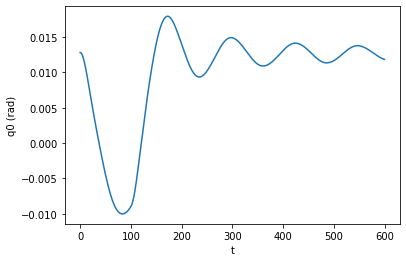

In [105]:
plt.plot(t,np.radians(us_[:,0]) ,'-')
plt.xlabel('t')
plt.ylabel('q0 (rad)')
plt.show()

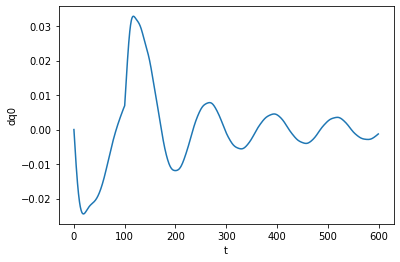

In [106]:
plt.plot(t,us_[:,1],'-')
plt.xlabel('t')
plt.ylabel('dq0')
plt.show()

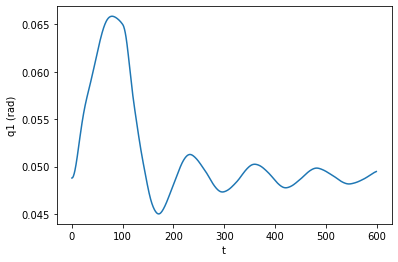

In [107]:
plt.plot(t, np.radians(us_[:,2]),'-')
plt.xlabel('t')
plt.ylabel('q1 (rad)')
plt.show()

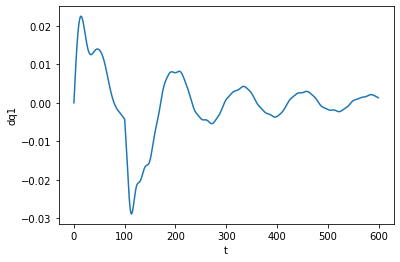

In [108]:
plt.plot(t, us_[:,3],'-')
plt.xlabel('t')
plt.ylabel('dq1')
plt.show()

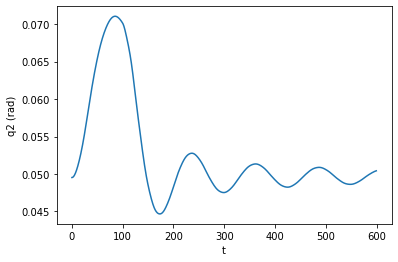

In [109]:
plt.plot(t, np.radians(us_[:,4]),'-')
plt.xlabel('t')
plt.ylabel('q2 (rad)')
plt.show()

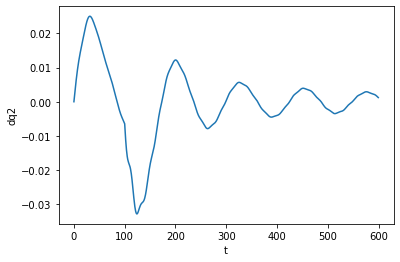

In [110]:
plt.plot(t, us_[:,5],'-')
plt.xlabel('t')
plt.ylabel('dq2')
plt.show()

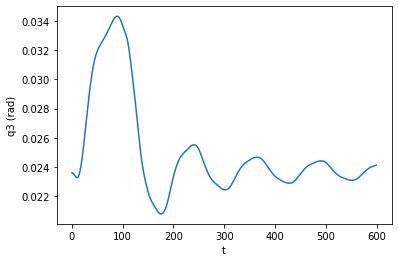

In [111]:
plt.plot(t, np.radians(us_[:,6]),'-')
plt.xlabel('t')
plt.ylabel('q3 (rad)')
plt.show()

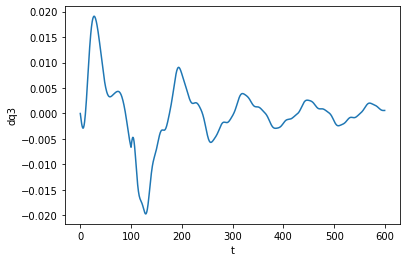

In [112]:
plt.plot(t, us_[:,7],'-')
plt.xlabel('t')
plt.ylabel('dq3')
plt.show()

In [113]:
X0=[x(alpha(us_[i,[0,2,4,6]]),0,l) for i in range(len(us_))]
Y0=[y(alpha(us_[i,[0,2,4,6]]),0,l) for i in range(len(us_))]
X1=[x(alpha(us_[i,[0,2,4,6]]),1,l) for i in range(len(us_))]
Y1=[y(alpha(us_[i,[0,2,4,6]]),1,l) for i in range(len(us_))]
X2=[x(alpha(us_[i,[0,2,4,6]]),2,l) for i in range(len(us_))]
Y2=[y(alpha(us_[i,[0,2,4,6]]),2,l) for i in range(len(us_))]
X3=[x(alpha(us_[i,[0,2,4,6]]),3,l) for i in range(len(us_))]
Y3=[y(alpha(us_[i,[0,2,4,6]]),3,l) for i in range(len(us_))]

In [114]:
X0_=[x(alpha(us_[i,[0,2,4,6]]),0,l) for i in range(1)]
Y0_=[y(alpha(us_[i,[0,2,4,6]]),0,l) for i in range(1)]
X1_=[x(alpha(us_[i,[0,2,4,6]]),1,l) for i in range(1)]
Y1_=[y(alpha(us_[i,[0,2,4,6]]),1,l) for i in range(1)]
X2_=[x(alpha(us_[i,[0,2,4,6]]),2,l) for i in range(1)]
Y2_=[y(alpha(us_[i,[0,2,4,6]]),2,l) for i in range(1)]
X3_=[x(alpha(us_[i,[0,2,4,6]]),3,l) for i in range(1)]
Y3_=[y(alpha(us_[i,[0,2,4,6]]),3,l) for i in range(1)]

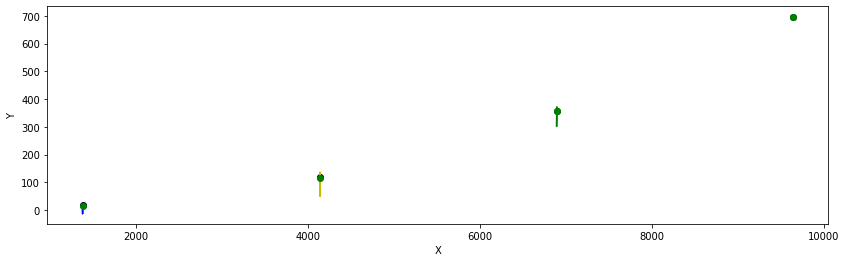

In [115]:
plt.figure(figsize=(14,4))
plt.plot(X0_,Y0_, 'o', color='black')
plt.plot(X1_,Y1_, 'o', color='black')
plt.plot(X2_,Y2_, 'o', color='black')
plt.plot(X3_,Y3_, 'o', color='black')

# dynamic
plt.plot(X0,Y0,'b')
plt.plot(X1,Y1,'y')
plt.plot(X2,Y2,'g')
plt.plot(X3,Y3,'r')

plt.plot(x(alpha(us_[-1,[0,2,4,6]]),0,l),y(alpha(us_[-1,[0,2,4,6]]),0,l), 'o', color='green')
plt.plot(x(alpha(us_[-1,[0,2,4,6]]),1,l),y(alpha(us_[-1,[0,2,4,6]]),1,l), 'o', color='green')
plt.plot(x(alpha(us_[-1,[0,2,4,6]]),2,l),y(alpha(us_[-1,[0,2,4,6]]),2,l), 'o', color='green')
plt.plot(x(alpha(us_[-1,[0,2,4,6]]),3,l),y(alpha(us_[-1,[0,2,4,6]]),3,l), 'o', color='green')

# plt.plot(x0, y0)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [116]:
us_[0,0]

0.7331318501868566

In [117]:
us_[0,2]

2.7956857962718002

In [118]:
us_[0,4]

2.837803967849071

In [119]:
us_[0,6]

1.3518677796322582

In [120]:
us_[0,0]+us_[0,2]+us_[0,4]+us_[0,6]

7.718489393939986

### Pipe-tip tension

In [121]:
coordinates=us[:,[0,2,4,6]]
velocities=us[:,[1,3,5,7]]

In [122]:
alp_=[]
for i in range(len(us)):
    alp_.append(alpha(coordinates[i]))
alp_=np.matrix(alp_)    

In [123]:
velocities.shape

(1200, 4)

In [124]:
velocities_0=velocities[:-1]
velocities_1=velocities[1:]

In [125]:
coordinates.shape, velocities.shape

((1200, 4), (1200, 4))

In [126]:
startTime1 = datetime.now()

add4=functools.partial(C, l=l, mn=mn, In=In, mi=mi)
add4__C =np.array(list(map(add4, coordinates, velocities)))

print(datetime.now() - startTime1)

0:01:10.055003


In [127]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, coordinates)))

add2=functools.partial(M, l=l, mn=mn, In=In, mi=mi)
add2__M =np.array(list(map(add2, coordinates)))

add3=functools.partial(H,  l=l)
add3__H =np.array(list(map(add3, alp_.tolist(), coordinates, velocities)))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, coordinates)))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, coordinates, alp_.tolist())))

print(datetime.now() - startTime)

0:00:02.074958


In [128]:
velocities_1.shape

(1199, 4)

In [129]:
add5__f.shape

(1200, 4, 1)

In [130]:
add6__g.shape

(1200, 4, 1)

In [131]:
add3__H.shape

(1200, 4, 4)

In [132]:
tmp__1=pinv(add1__Jv[:-1].transpose(0, 2, 1))
#here
tmp__2=np.matmul(add2__M[:-1], ((np.radians(velocities_1).reshape(dim2,4,1) - 
                              np.radians(velocities_0).reshape(dim2,4,1))/dt))\
            + np.matmul(add3__H[:-1], np.radians(velocities[:-1]).reshape(dim2,4,1)) \
            + np.matmul(add4__C[:-1], np.radians(velocities[:-1]).reshape(dim2,4,1)) \
            + add5__f[:-1] \
            + add6__g[:-1]

In [133]:
tmp__=np.matmul(tmp__1, tmp__2)

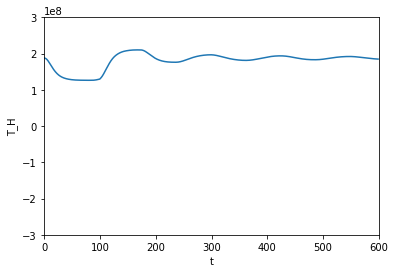

In [134]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'-')
plt.xlim([-1, dim1//2])
plt.ylim([-300000000, 300000000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

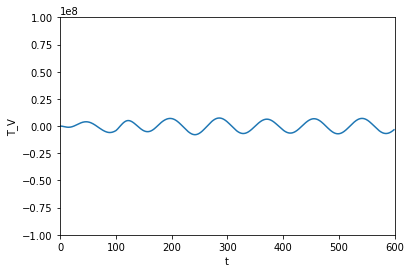

In [135]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'-')
plt.xlim([-1, dim1//2])
plt.ylim([-100000000, 100000000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [136]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([2.10198178e+08]), array([7420762.04724669]))

In [137]:
min(tmp__[:,0]), min(tmp__[:,1])

(array([1.26352622e+08]), array([-7917150.06672654]))

In [138]:
# (array([28319143.73486871]), array([25605994.71854329])) just waves
# (array([28491881.95694733]), array([25520818.9120822]))  positive Fx
# (array([28146301.99196166]), array([25687403.50463529])) negative Fx
# (array([30076743.25808775]), array([25019302.28641659])) large positive Fx
# (array([26618614.2824719]),  array([26179692.06953637])) large negative Fx
# (array([3953150.66297572]),  array([1508270.46574422]))  fip=1e10
# (array([6746771.13788591]),  array([10057989.37909701])) max_t = 300
# (array([2084853.78862965]),  array([766900.49862976])) fip=1e9
# (array([1518705.92013393]),  array([361011.0471009])) fip=5e8
# (array([2212275.89406135]),  array([634267.05259892])) fip=4e8

In [139]:
# ρa = 1.200 * 10**3 # g/m3
# ρs=7.850 * 10**6
# di = 0.6900 # m
# do = 0.7610 

In [140]:
# Q=(ρa-ρs)*(di/do)**2+ρs  # g/m3

In [141]:
# length=1000

In [142]:
# V=math.pi * (do/2)**2 * length - math.pi * (di/2)**2 * length #m3

In [143]:
#m3

In [144]:
# Q*V/length/1000